# Census Income Analysis

## Project description


**Introduction to the Census Income Analysis**

The Census Income dataset, an intricate compilation of demographic and educational data, seeks to provide insights into an individual's annual income category: whether it exceeds $50K or not. This analysis lends itself to a binary classification problem, aiming to demystify the relationship between various socio-economic indicators and earning potential.

The dataset encompasses the following variables:

* **Age**: A numerical representation of an individual's age.

* **Workclass**: The category of an individual's working class, such as private sector, government, or self-employed.

* **Education**: Qualitative data detailing the highest level of education attained.

* **Marital Status**: Describes an individual's marital status, including categories like single, married, or divorced.

* **Occupation**: The professional field or job role of the individual.

* **Relationship**: Describes family relationships, such as husband, wife, or child.

* **Race**: Categorizes individuals based on ethnicity.

* **Gender**: Male or Female.

* **Capital Gain and Capital Loss**: Numerical variables detailing an individual's capital transactions.

* **Hours Worked Per Week**: Numerical data showing the number of work hours in a week.

* **Native Country**: The country of origin for the individual.

* **Over Threshold**: Our target variable; indicates whether an individual earns more (1) or less (0) than USD 50 K annually.


The methodology of our analysis can be delineated as follows:

**Data Load and Preliminary Exploration**: An initial sweep of the dataset, understanding its structure, size, and basic statistical properties.

**Data Cleansing**: Systematically addressing anomalies – missing values, outliers, and discrepancies.

**Memory Optimization**: Refining data structures and types, ensuring efficient storage and faster computation.

**Exploratory Data Analysis and Visualization**: A quantitative and visual deep-dive into the data to unearth patterns, correlations, and outliers.

**Feature Engineering**: Enhancing the dataset by generating new features, conducting one-hot encoding for categorical variables, and implementing scaling for numerical attributes.

**Modeling**: Beginning with foundational models like Logistic Regression, Naive Bayes, and Decision Trees, the analysis subsequently delves into advanced algorithms such as RandomForest, XGBoost, and CatBoost. A comparative evaluation determines the most proficient model.

## pip install

In [84]:
!pip install datasets
!pip install tqdm
!pip install catboost
!pip install imbalanced-learn

## Import required libraries

In [168]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN # for over-sampling
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
from tqdm.notebook import tqdm_notebook
from joblib import Parallel, delayed
from tqdm import tqdm

## ETL & Initial data exploration

In [86]:
pd.__version__

'1.5.3'

In [87]:
dataset_train = load_dataset("mstz/adult", "income")["train"]
dataset_test = load_dataset("mstz/adult", "income")["test"]

In [88]:
df_train = pd.DataFrame(dataset_train)
df_test = pd.DataFrame(dataset_test)

In most ML workflows, *the training and test datasets are kept separate during preprocessing* to ensure that the model has no knowledge of the test dataset during training. This helps in validating the model's performance in a real-world scenario, where it would encounter unseen data.

In [89]:
# how much data do we have?
print(df_train.shape)
print(df_test.shape)

(36631, 14)
(12211, 14)


In [90]:
# are there duplicates?
print(df_train.duplicated().any(), df_train.duplicated().sum())
print(df_test.duplicated().any(), df_test.duplicated().sum())

True 29
True 5


In [91]:
# removing duplicates
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

print(df_train.duplicated().any(), df_train.duplicated().sum())
print(df_test.duplicated().any(), df_test.duplicated().sum())

False 0
False 0


Note that the duplicate removal step we've just done is one of the few steps that can be performed individually on both datasets *since it doesn't involve learning or transferring any information between the datasets*.

In [92]:
# are there any missing values?
print(f"Missing values in training set: {df_train.isna().sum().sum()}")
print(f"Missing values in test set: {df_test.isna().sum().sum()}")

Missing values in training set: 0
Missing values in test set: 0


In [93]:
# check for target variable distribution
print(f"Training set:\n{df_train.over_threshold.value_counts(normalize=True)}")
print()
print(f"Test set:\n{df_test.over_threshold.value_counts(normalize=True)}")

Training set:
0    0.760669
1    0.239331
Name: over_threshold, dtype: float64

Test set:
0    0.76061
1    0.23939
Name: over_threshold, dtype: float64


The target variable **over_threshold** exhibits almost identical distributions in both the training and test sets. In each set, approximately 76.07% of the samples fall into the '0' category, while the remaining 23.93% are in the '1' category.

This uniformity in distribution between the training and test sets is favorable, as it suggests that the test set is a good representation of the overall data and should provide a reliable measure of model performance.

With a ~76/24 split, the class imbalance is not extreme, but it's still significant enough that it might affect the model's performance, especially in correctly predicting the minority class. I will consider techniques like resampling, using appropriate evaluation metrics, or leveraging model-specific parameters to handle this imbalance effectively.

Next, I combine two sets for the memory optimization step since it doesn't involve "learning" from the data in the way that scaling or encoding might. I will separate the data again after the step is finished.

In [94]:
df_train['test'] = False
df_test['test'] = True

df_combined = pd.concat([df_test, df_train], ignore_index=True)

In [95]:
df_combined.describe()

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold
count,48808.000000,48808.000000,48808.000000,48808.000000,4.880800e+04,48808.000000,48808.000000
mean,38.648910,1079.819312,87.563268,10.078286,1.896731e+05,40.425197,0.239346
std,13.708499,7454.559781,403.138279,2.570464,1.056133e+05,12.392140,0.426689
min,17.000000,0.000000,0.000000,1.000000,1.228500e+04,1.000000,0.000000
25%,28.000000,0.000000,0.000000,9.000000,1.175550e+05,40.000000,0.000000
50%,37.000000,0.000000,0.000000,10.000000,1.781505e+05,40.000000,0.000000
75%,48.000000,0.000000,0.000000,12.000000,2.376472e+05,45.000000,0.000000
max,90.000000,99999.000000,4356.000000,16.000000,1.490400e+06,99.000000,1.000000


In [96]:
df_combined.head()

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,over_threshold,test
0,30,0.0,2258.0,10,257295,40,Never-married,South,Sales,Asian-Pac-Islander,Other-relative,True,Self-emp-not-inc,0,True
1,38,0.0,0.0,9,208358,40,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,1,True
2,30,0.0,0.0,9,312767,40,Never-married,United-States,Sales,Black,Unmarried,False,State-gov,0,True
3,38,0.0,0.0,6,200904,40,Separated,United-States,Adm-clerical,Black,Unmarried,False,State-gov,0,True
4,45,10520.0,0.0,13,154430,50,Widowed,United-States,Prof-specialty,White,Not-in-family,False,Private,1,True


In [97]:
cols = df_combined.columns.to_list()
print(cols)

['age', 'capital_gain', 'capital_loss', 'education', 'final_weight', 'hours_worked_per_week', 'marital_status', 'native_country', 'occupation', 'race', 'relationship', 'is_male', 'workclass', 'over_threshold', 'test']


The "fnlwgt" or "final weight" attribute in the Adult dataset represents the number of people the census believes the entry represents, which assists researchers in making population-level inferences.

## Data cleansing & Memory optimization

In [98]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48808 entries, 0 to 48807
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    48808 non-null  int64  
 1   capital_gain           48808 non-null  float64
 2   capital_loss           48808 non-null  float64
 3   education              48808 non-null  int64  
 4   final_weight           48808 non-null  int64  
 5   hours_worked_per_week  48808 non-null  int64  
 6   marital_status         48808 non-null  object 
 7   native_country         48808 non-null  object 
 8   occupation             48808 non-null  object 
 9   race                   48808 non-null  object 
 10  relationship           48808 non-null  object 
 11  is_male                48808 non-null  bool   
 12  workclass              48808 non-null  object 
 13  over_threshold         48808 non-null  int64  
 14  test                   48808 non-null  bool   
dtypes:

### Ints

In [99]:
(
    df_combined
    [cols]
    .select_dtypes(int)
    .describe()
)

,age,education,final_weight,hours_worked_per_week,over_threshold
count,48808.000000,48808.000000,4.880800e+04,48808.000000,48808.000000
mean,38.648910,10.078286,1.896731e+05,40.425197,0.239346
std,13.708499,2.570464,1.056133e+05,12.392140,0.426689
min,17.000000,1.000000,1.228500e+04,1.000000,0.000000
25%,28.000000,9.000000,1.175550e+05,40.000000,0.000000
50%,37.000000,10.000000,1.781505e+05,40.000000,0.000000
75%,48.000000,12.000000,2.376472e+05,45.000000,0.000000
max,90.000000,16.000000,1.490400e+06,99.000000,1.000000


In [100]:
# how much can be stored as int8?
print(np.iinfo(np.int8))
# int16
print(np.iinfo(np.int16))
# int32
print(np.iinfo(np.int32))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------



In [101]:
(
    df_combined
    [cols]
    .astype({"age": "int8", "education": "int8", "hours_worked_per_week": "int8", "over_threshold": "int8"})
    .memory_usage(deep=True)
    .sum()
)

21155446

### Floats

In [102]:
(
    df_combined
    [cols]
    .select_dtypes(float)
    .describe()
)

,capital_gain,capital_loss
count,48808.000000,48808.000000
mean,1079.819312,87.563268
std,7454.559781,403.138279
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,99999.000000,4356.000000


It seems like both float-variables can be converted into int32-variables.

In [103]:
df_combined.query("capital_gain>0").sample(20)

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,over_threshold,test
12466,50,7298.0,0.0,9,95469,45,Married-civ-spouse,United-States,Adm-clerical,White,Husband,True,Private,1,False
47521,40,2174.0,0.0,9,149102,60,Married-spouse-absent,Poland,Handlers-cleaners,White,Not-in-family,True,Private,0,False
35926,49,99999.0,0.0,14,362795,80,Divorced,Mexico,Prof-specialty,White,Unmarried,True,Self-emp-inc,1,False
22524,56,15024.0,0.0,9,176079,24,Married-civ-spouse,United-States,Adm-clerical,White,Wife,False,Private,1,False
7407,20,1055.0,0.0,10,206671,50,Never-married,United-States,?,White,Own-child,True,?,0,True
20977,56,2580.0,0.0,5,225927,40,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,0,False
16360,51,7298.0,0.0,9,162745,50,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,1,False
40040,35,3674.0,0.0,7,538583,40,Separated,United-States,Transport-moving,Black,Not-in-family,True,Private,0,False
11118,42,99999.0,0.0,14,269733,80,Married-civ-spouse,United-States,Sales,White,Husband,True,Self-emp-not-inc,1,True
42541,36,2907.0,0.0,9,544686,40,Never-married,Nicaragua,Adm-clerical,White,Other-relative,False,Private,0,False


In [104]:
df_combined.query("capital_loss>0").sample(15)

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,over_threshold,test
44349,41,0.0,1485.0,9,204410,44,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,1,False
21899,45,0.0,1977.0,14,213140,52,Married-civ-spouse,United-States,Prof-specialty,White,Husband,True,Private,1,False
37467,34,0.0,1564.0,15,98283,40,Never-married,India,Tech-support,Asian-Pac-Islander,Not-in-family,True,Private,1,False
9579,54,0.0,1902.0,10,151580,40,Married-civ-spouse,United-States,Prof-specialty,White,Husband,True,State-gov,1,True
40781,37,0.0,1887.0,13,218184,40,Married-civ-spouse,United-States,Prof-specialty,White,Husband,True,Local-gov,1,False
47090,32,0.0,1902.0,10,110171,40,Married-civ-spouse,United-States,Prof-specialty,White,Wife,False,State-gov,1,False
28288,34,0.0,1977.0,13,181091,45,Married-civ-spouse,United-States,Exec-managerial,White,Husband,True,Private,1,False
17426,55,0.0,2001.0,9,123382,40,Separated,United-States,?,Black,Not-in-family,False,?,0,False
8459,31,0.0,1590.0,13,190772,35,Never-married,?,Exec-managerial,White,Own-child,False,Private,0,True
7070,42,0.0,1408.0,10,83411,40,Divorced,United-States,Exec-managerial,White,Not-in-family,True,Private,0,True


In [105]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48808 entries, 0 to 48807
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    48808 non-null  int64  
 1   capital_gain           48808 non-null  float64
 2   capital_loss           48808 non-null  float64
 3   education              48808 non-null  int64  
 4   final_weight           48808 non-null  int64  
 5   hours_worked_per_week  48808 non-null  int64  
 6   marital_status         48808 non-null  object 
 7   native_country         48808 non-null  object 
 8   occupation             48808 non-null  object 
 9   race                   48808 non-null  object 
 10  relationship           48808 non-null  object 
 11  is_male                48808 non-null  bool   
 12  workclass              48808 non-null  object 
 13  over_threshold         48808 non-null  int64  
 14  test                   48808 non-null  bool   
dtypes:

In [106]:
(
    df_combined
    [cols]
    .astype({"age": "int8",
             "education": "int8",
             "hours_worked_per_week": "int8",
             "over_threshold": "int8",
             "capital_gain": "int32",
             "capital_loss": "int32"})
    .memory_usage(deep=True)
    .sum()
)

20764982

In [107]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48808 entries, 0 to 48807
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    48808 non-null  int64  
 1   capital_gain           48808 non-null  float64
 2   capital_loss           48808 non-null  float64
 3   education              48808 non-null  int64  
 4   final_weight           48808 non-null  int64  
 5   hours_worked_per_week  48808 non-null  int64  
 6   marital_status         48808 non-null  object 
 7   native_country         48808 non-null  object 
 8   occupation             48808 non-null  object 
 9   race                   48808 non-null  object 
 10  relationship           48808 non-null  object 
 11  is_male                48808 non-null  bool   
 12  workclass              48808 non-null  object 
 13  over_threshold         48808 non-null  int64  
 14  test                   48808 non-null  bool   
dtypes:

### Objects

Check cardinality of the categorical variables.

In [108]:
df_combined["marital_status"].value_counts()

Married-civ-spouse       22370
Never-married            16093
Divorced                  6632
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital_status, dtype: int64

In [109]:
df_combined["native_country"].value_counts()

United-States                 43804
Mexico                          947
?                               856
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        87
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                        

In [110]:
df_combined["occupation"].value_counts()

Prof-specialty       6167
Craft-repair         6106
Exec-managerial      6082
Adm-clerical         5606
Sales                5501
Other-service        4921
Machine-op-inspct    3021
?                    2807
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1487
Tech-support         1445
Protective-serv       982
Priv-house-serv       241
Armed-Forces           15
Name: occupation, dtype: int64

In [111]:
df_combined["race"].value_counts()

White                 41731
Black                  4683
Asian-Pac-Islander     1518
Amer-Indian-Eskimo      470
Other                   406
Name: race, dtype: int64

In [112]:
df_combined["relationship"].value_counts()

Husband           19707
Not-in-family     12567
Own-child          7573
Unmarried          5124
Wife               2331
Other-relative     1506
Name: relationship, dtype: int64

In [113]:
(
    df_combined
    [cols]
    .astype({"age": "int8",
             "education": "int8",
             "hours_worked_per_week": "int8",
             "over_threshold": "int8",
             "capital_gain": "int32",
             "capital_loss": "int32",
             "race": "category",
             "relationship": "category",
             "marital_status": "category"})
    .memory_usage(deep=True)
    .sum()
)

11148085

In [114]:
def memory_optimization(df):
  """
  This function optimizes the memory usage of a DataFrame by changing data types and performs data cleaning. Specifically:
  1. Replaces '?' with more descriptive placeholders in 'occupation', 'workclass', and 'native_country' columns.
  2. Converts several columns to appropriate data types for memory efficiency (like 'int8', 'int32', and 'category').
  3. Drops the 'final_weight' column from the DataFrame.
  """

  cols = df.columns.to_list()

  return (df
          [cols]
          .assign(occupation=df.occupation.replace({"?": "Other"}).astype("category"),
                  workclass=df.workclass.replace({"?": "Other"}).astype("category"),
                  native_country=df.native_country.replace({"?": "Unknown"})) # high cardinality variable, so I leave it as "object"
          .astype({"age": "int8",
                   "education": "int8",
                   "hours_worked_per_week": "int8",
                   "over_threshold": "int8",
                   "capital_gain": "int32",
                   "capital_loss": "int32",
                   "race": "category",
                   "relationship": "category",
                   "marital_status": "category"})
          .drop("final_weight", axis=1)
          )

In [115]:
df_optimized = memory_optimization(df_combined)
df_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48808 entries, 0 to 48807
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    48808 non-null  int8    
 1   capital_gain           48808 non-null  int32   
 2   capital_loss           48808 non-null  int32   
 3   education              48808 non-null  int8    
 4   hours_worked_per_week  48808 non-null  int8    
 5   marital_status         48808 non-null  category
 6   native_country         48808 non-null  object  
 7   occupation             48808 non-null  category
 8   race                   48808 non-null  category
 9   relationship           48808 non-null  category
 10  is_male                48808 non-null  bool    
 11  workclass              48808 non-null  category
 12  over_threshold         48808 non-null  int8    
 13  test                   48808 non-null  bool    
dtypes: bool(2), category(5), int32(2), int

We managed to reduce memory usage from almost 5MB down to 1.3MB.

In [116]:
cols = df_optimized.columns.to_list()
num_cols = df_optimized.select_dtypes('integer').columns.to_list()[:-1]
cat_cols = df_optimized.select_dtypes(include=['category', 'object', 'bool']).columns.to_list()[:-1]

In [117]:
num_cols

['age', 'capital_gain', 'capital_loss', 'education', 'hours_worked_per_week']

## EDA

### Defining functions

In [118]:
sns.set_palette("pastel")

In [119]:
# separate training & test sets for further data preprocesing & EDA
df_optimized_train = df_optimized[df_optimized.test==False].drop('test', axis=1)
df_optimized_test = df_optimized[df_optimized.test==True].drop('test', axis=1)

In [120]:
def sns_histogram(df_train, df_test, x:str, bins:int=20, figsize=(12,4)):
    """
    Plots histograms for both training and test datasets side by side.

    Args:
    - df_train (pd.DataFrame): Training dataset.
    - df_test (pd.DataFrame): Test dataset.
    - x (str): Column name for which the histogram is plotted.
    - bins (int, optional): Number of histogram bins. Defaults to 10.
    - figsize (tuple, optional): Size of the figure. Defaults to (12,4).

    Returns:
    - Plots histograms.
    """

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.histplot(data=df_train, x=x, bins=bins, kde=True, ax=axes[0])
    axes[0].set_title('Training Dataset')

    sns.histplot(data=df_test, x=x, bins=bins, kde=True, ax=axes[1])
    axes[1].set_title('Test Dataset')

    plt.tight_layout()
    return plt.show()

In [121]:
def sns_countplot(df_train, df_test, x:str, hue="over_threshold", figsize=(24,6)):
    """
    Plots count plots side by side for a specified categorical feature from training and test datasets.

    Args:
    - df_train (pd.DataFrame): The training dataset.
    - df_test (pd.DataFrame): The test dataset.
    - x (str): The name of the categorical column to be plotted.
    - hue (str, optional): The column name to color-code the bars. Defaults to "over_threshold".
    - figsize (tuple, optional): The size of the figure. Defaults to (24,6).

    Returns:
    - None: Displays the count plots side by side.
    """

    # Initialize a figure with given figsize
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Plotting for the training data
    sns.countplot(data=df_train, x=x, hue=hue, ax=axes[0])
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_title('Training Data')

    # Plotting for the test data
    sns.countplot(data=df_test, x=x, hue=hue, ax=axes[1])
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].set_title('Test Data')

    # Adjust layout
    plt.tight_layout()

    return plt.show()

In [122]:
def sns_boxplot(df_train, df_test, x:str, y:str, hue=None, figsize=(24,6)):
    """
    Create side-by-side box plots for training and test data using Seaborn.

    Args:
    - df_train (DataFrame): The training data to be plotted.
    - df_test (DataFrame): The test data to be plotted.
    - x (str): The name of the categorical variable for the x-axis.
    - y (str): The name of the continuous variable for the y-axis.
    - hue (str, optional): The name of the categorical variable for grouping. Defaults to None.
    - figsize (tuple, optional): Figure size. Defaults to (24,6).
    - palette (str or list, optional): Color palette to use for plots. Can be a Seaborn palette or a list of colors. Defaults to "pastel".

    Returns:
    - None. Displays the boxplots.
    """

    # Initialize a figure with given figsize
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Plotting for the training data
    sns.boxplot(data=df_train, x=x, y=y, hue=hue, ax=axes[0])
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_title('Training Data')

    # Plotting for the test data
    sns.boxplot(data=df_test, x=x, y=y, hue=hue, ax=axes[1])
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].set_title('Test Data')

    # Adjust layout
    plt.tight_layout()

    return plt.show()

In [123]:
def correlation_heatmap(df_train, df_test, num_cols, method='pearson', figsize=(16,6)):
    """
    Generate side-by-side correlation heatmaps for training and test data.

    Args:
    - df_train (DataFrame): The training dataset.
    - df_test (DataFrame): The test dataset.
    - num_cols (list): List of numerical columns to consider for correlation.
    - target (str): The target column.
    - figsize (tuple, optional): Figure size. Defaults to (16,6).

    Returns:
    - None. Displays the heatmap.
    """

    # Extend num_cols to include the target column
    cols = num_cols + ['over_threshold']

    # Compute correlation matrices
    train_corr = df_train[cols].corr(method=method)
    test_corr = df_test[cols].corr(method=method)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Heatmap for training data
    sns.heatmap(train_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title('Training Data Correlation')

    # Heatmap for test data
    sns.heatmap(test_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title('Test Data Correlation')

    # Adjust layout
    plt.tight_layout()
    return plt.show()


### Histograms

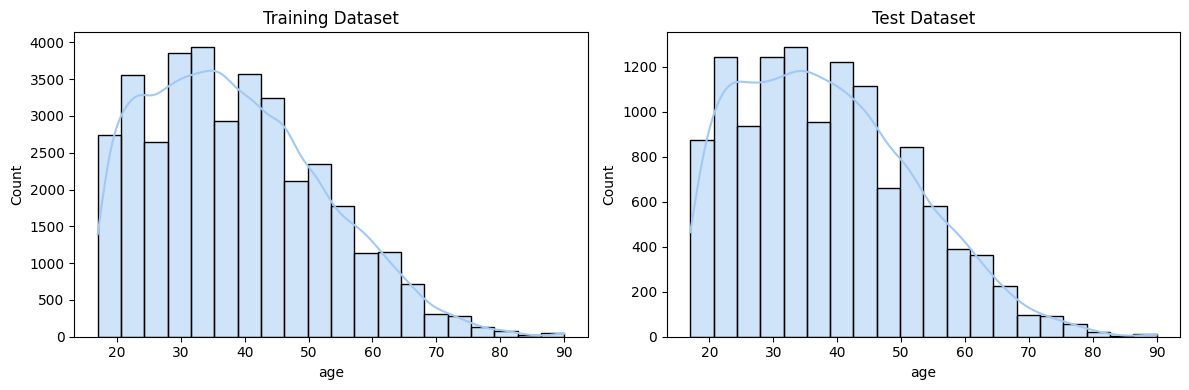

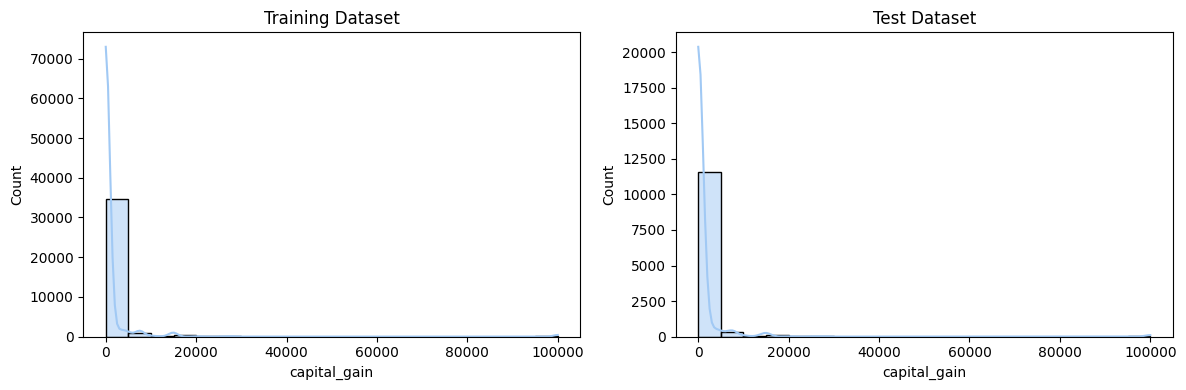

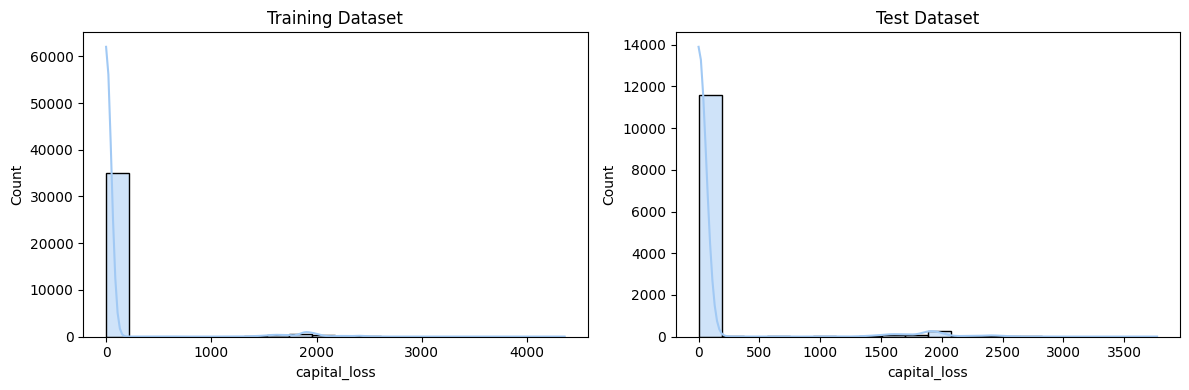

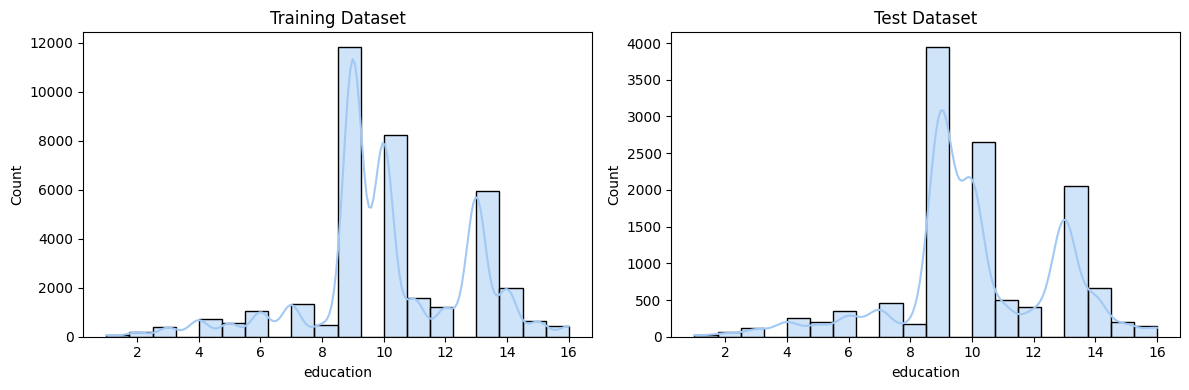

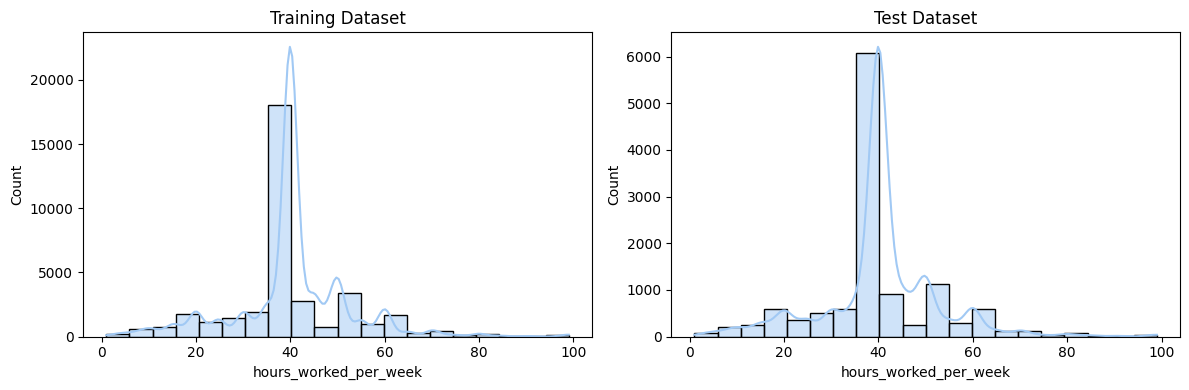

In [124]:
for col in num_cols:
    sns_histogram(df_optimized_train, df_optimized_test, col)
    plt.show()

### Countplots

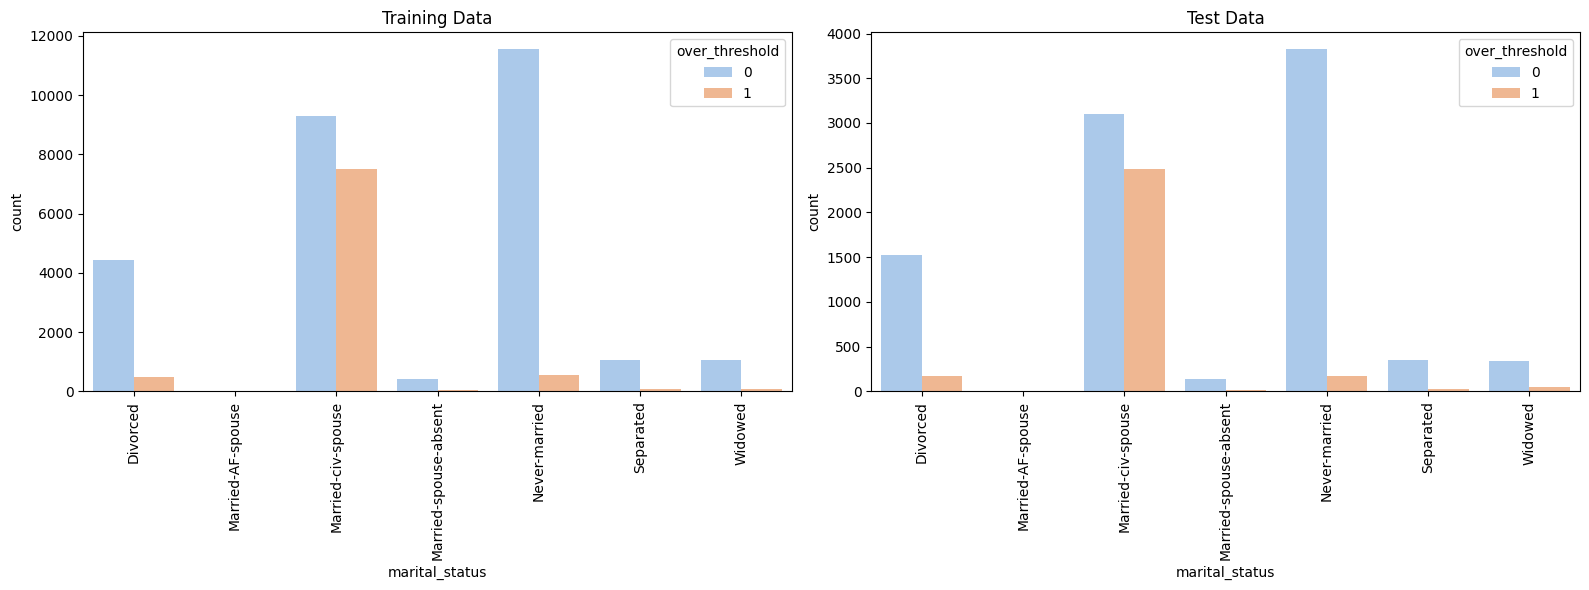

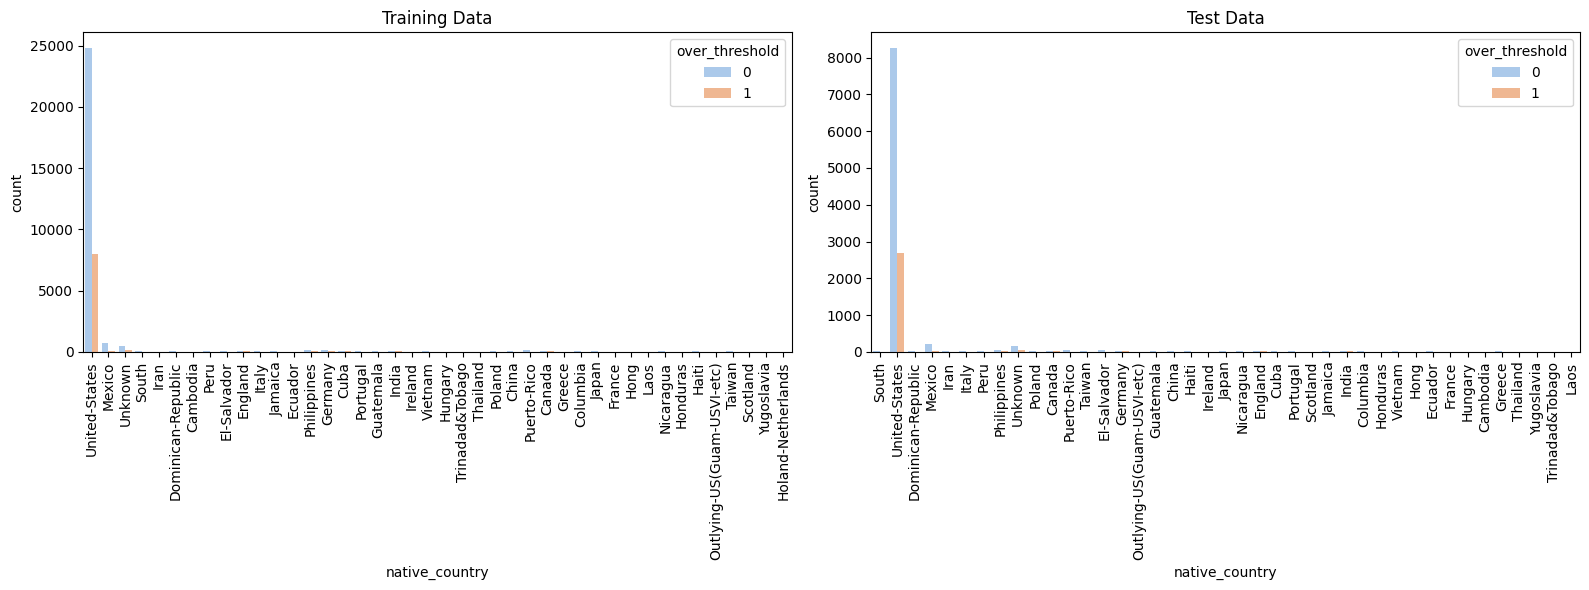

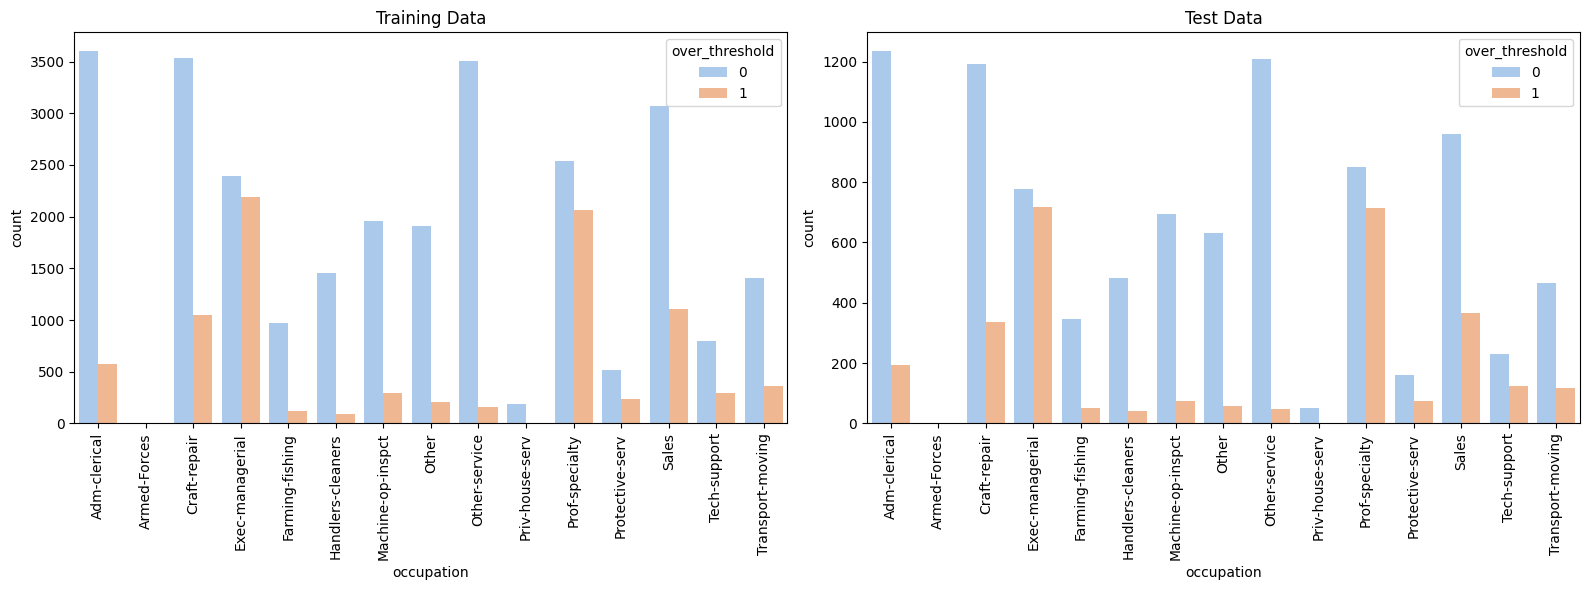

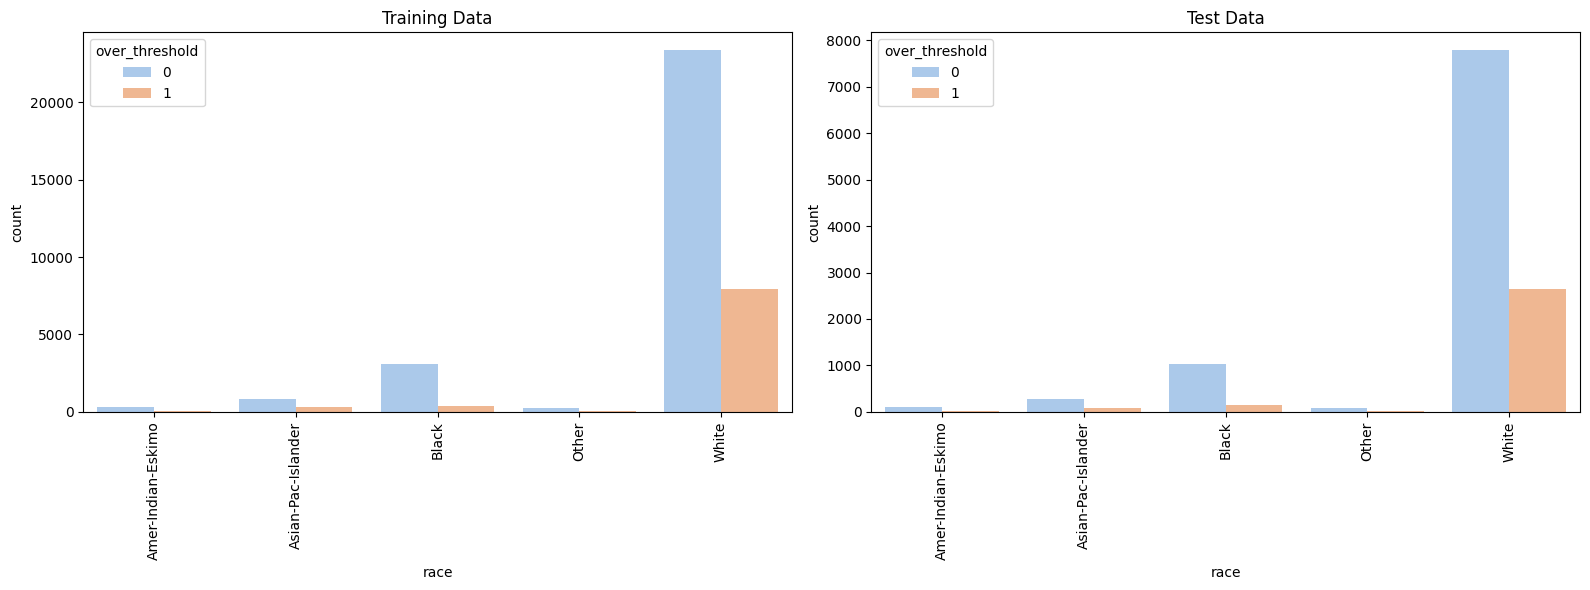

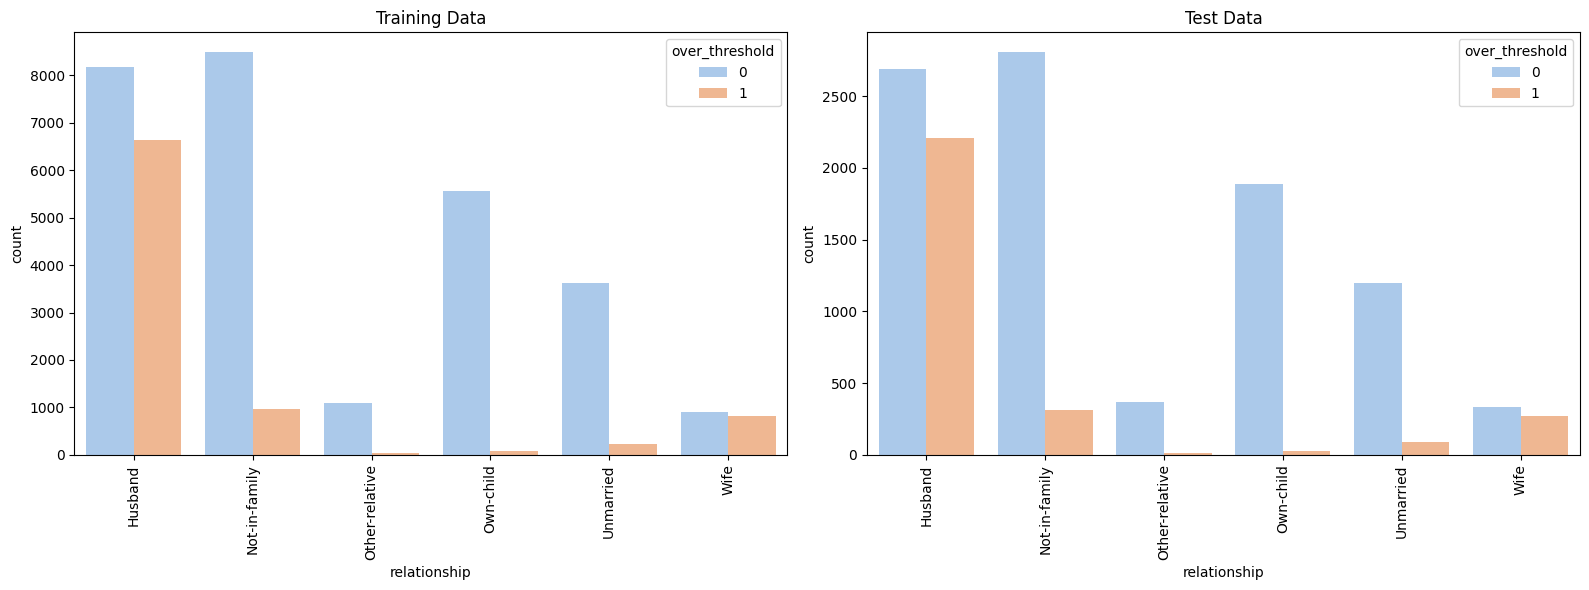

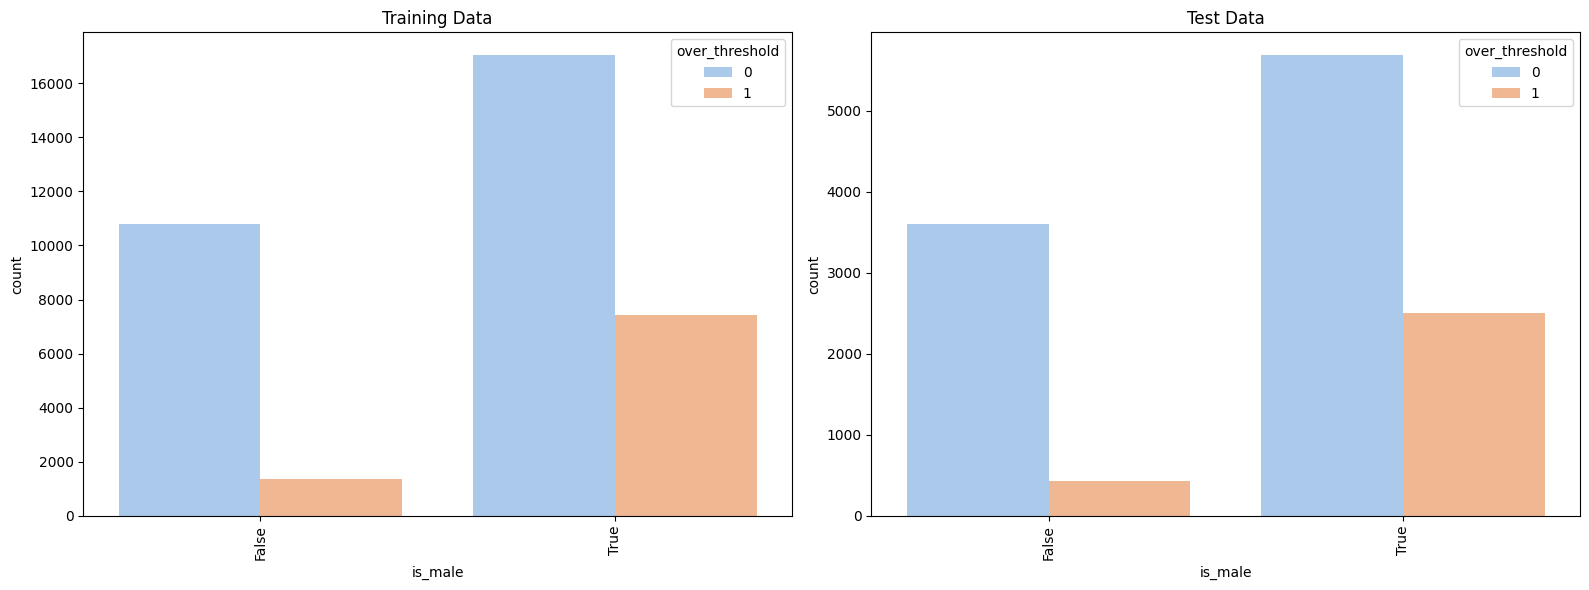

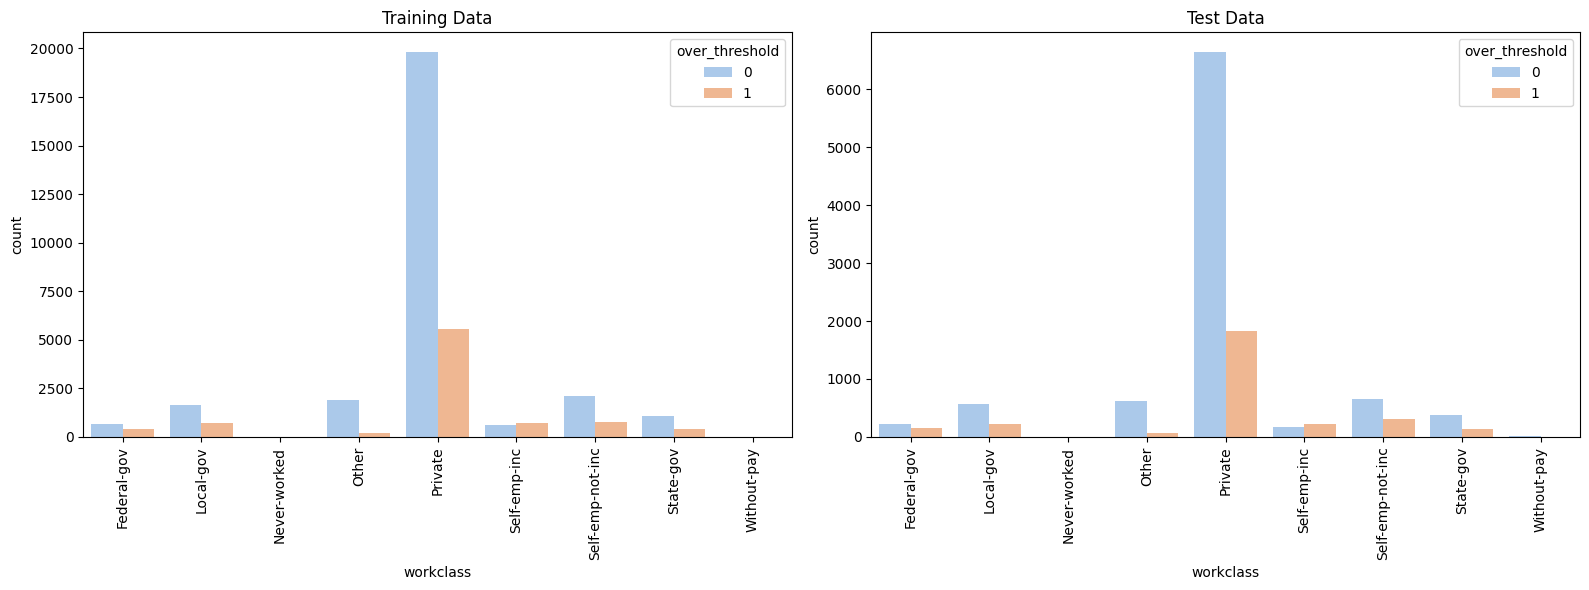

In [125]:
for col in cat_cols:
    sns_countplot(df_optimized_train, df_optimized_test, col, hue='over_threshold', figsize=(16,6))
    plt.show()

### Boxplots

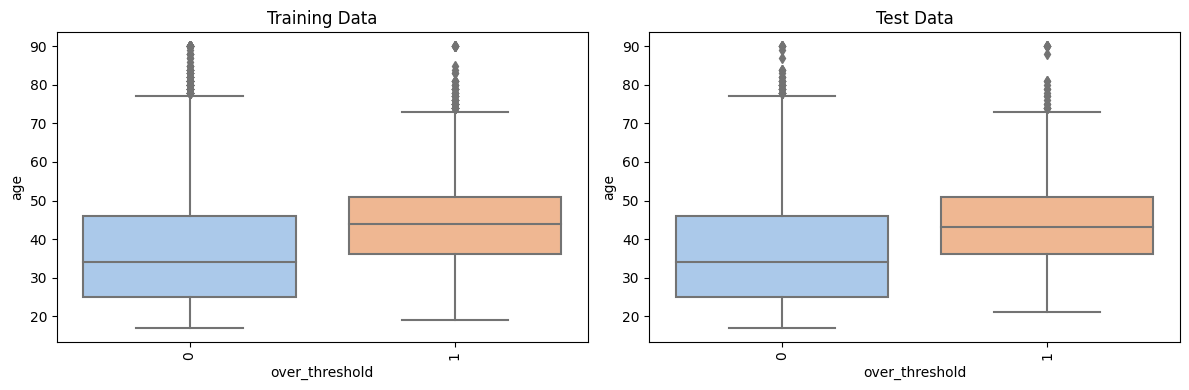

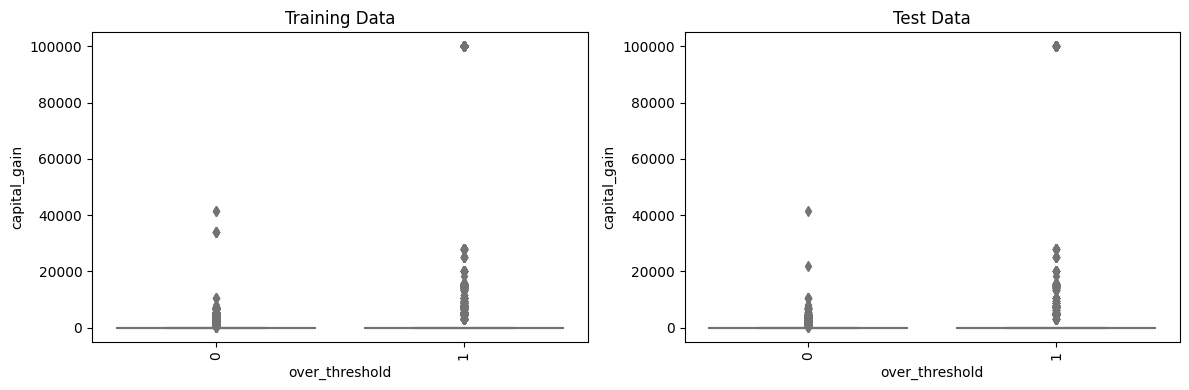

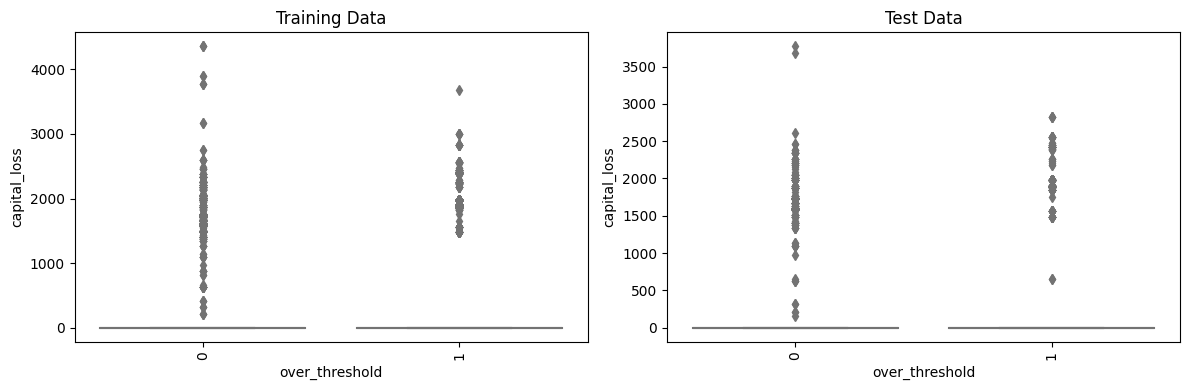

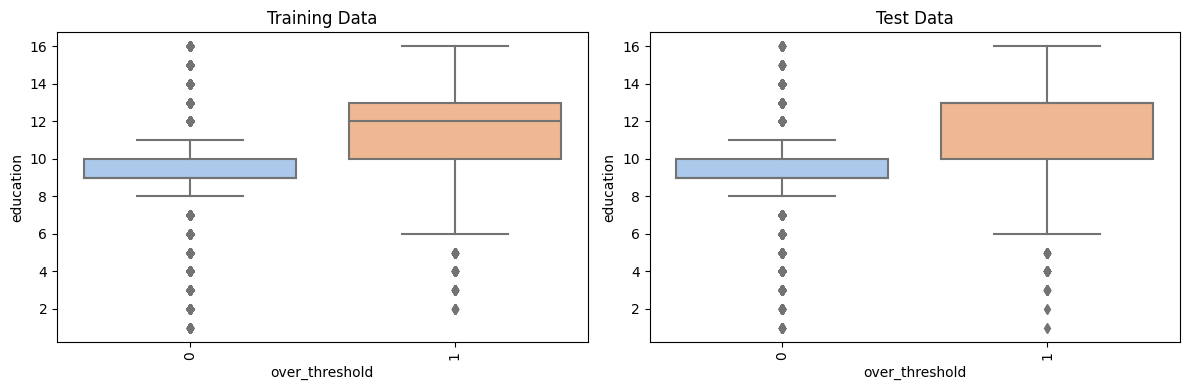

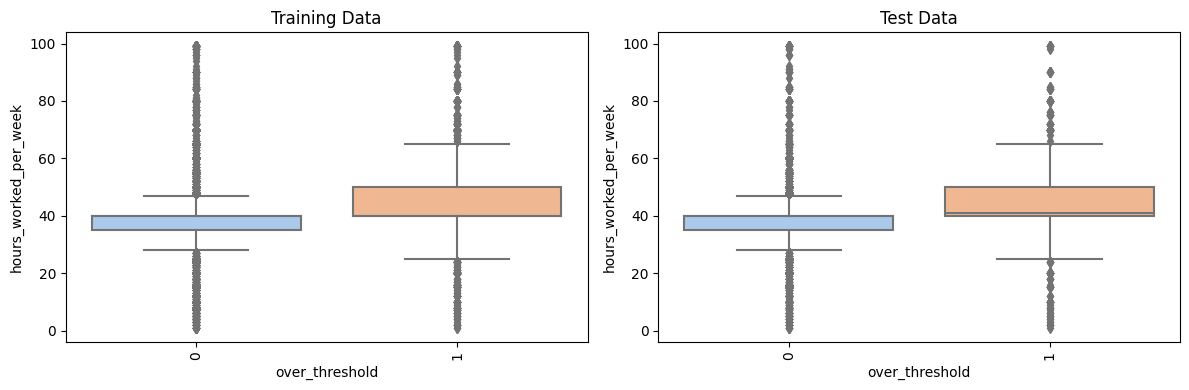

In [126]:
for col in num_cols:
    sns_boxplot(df_optimized_train,
                df_optimized_test,
                x='over_threshold',
                y=col,
                figsize=(12,4))
    plt.show()

### Gender pay gap investigation

Interesting! What are the reasons behind the gender pay gap?? Let's investigate a little bit further to get a richer understanding!

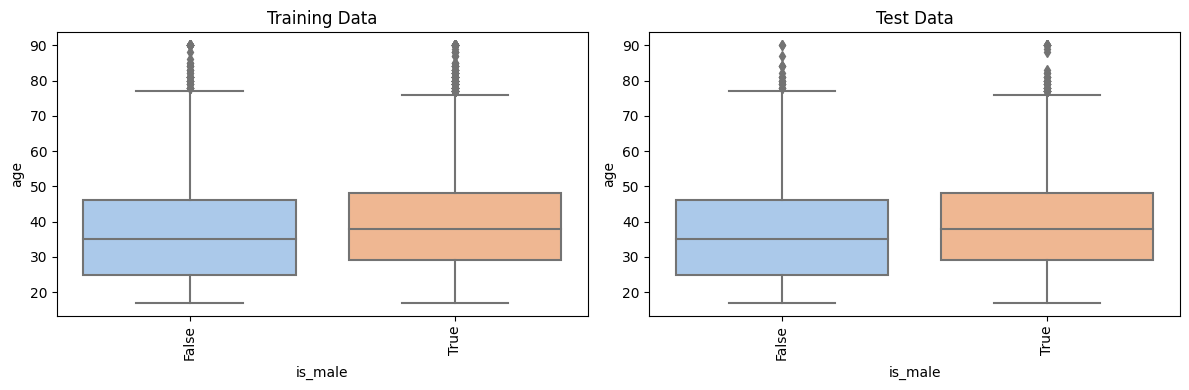

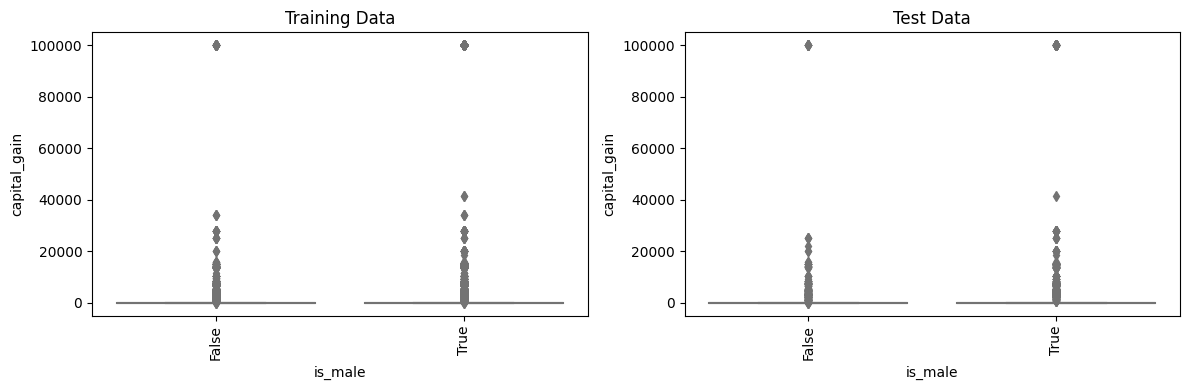

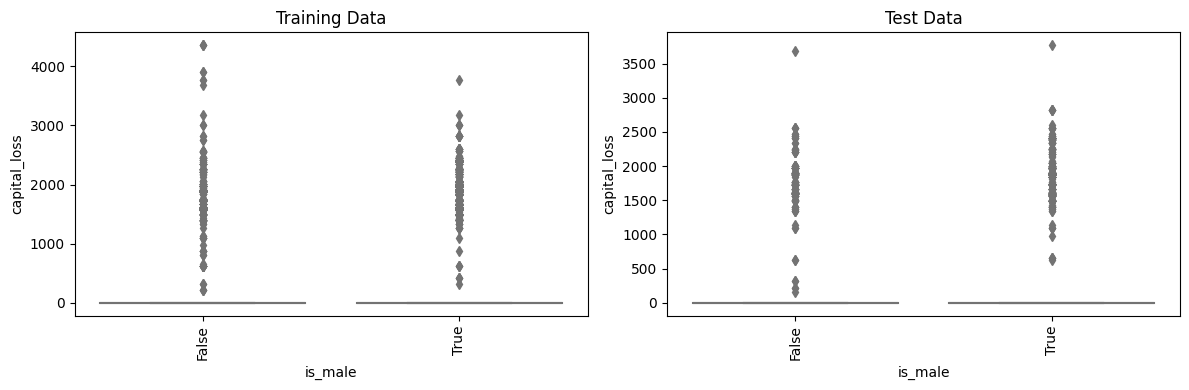

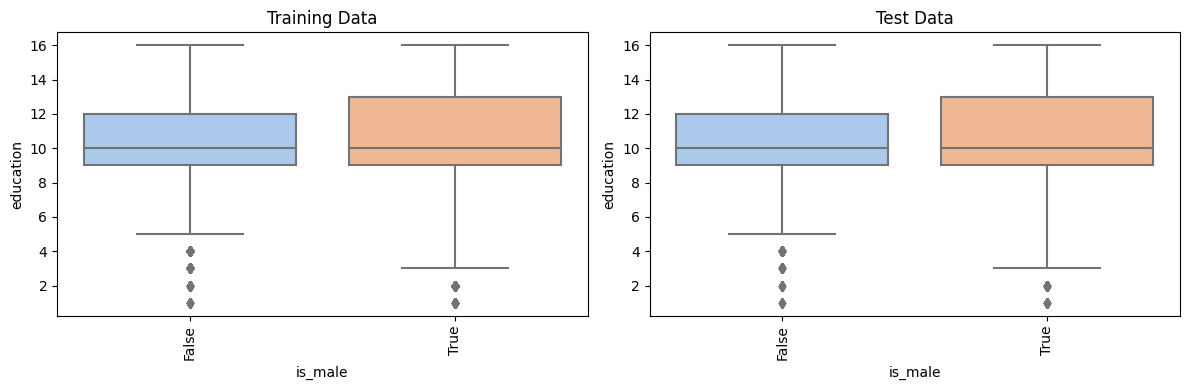

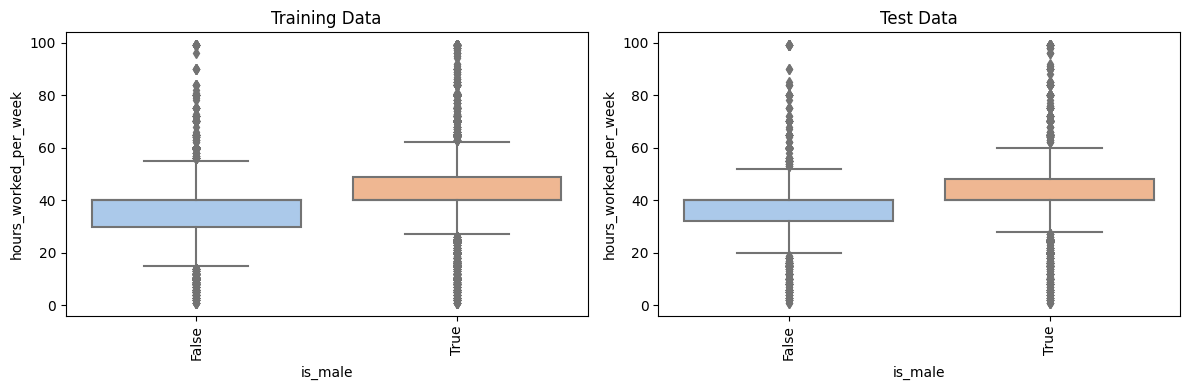

In [127]:
for col in num_cols:
    sns_boxplot(df_optimized_train,
                df_optimized_test,
                x='is_male',
                y=col,
                figsize=(12,4))
    plt.show()

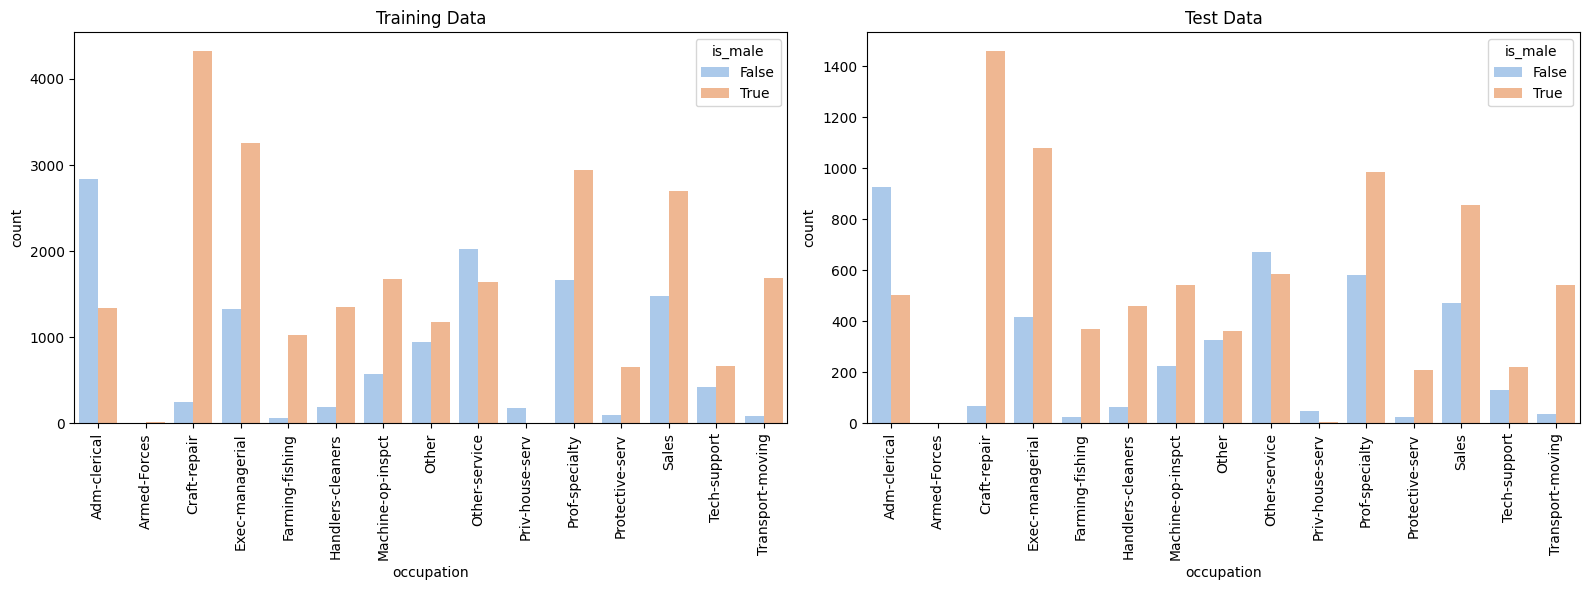

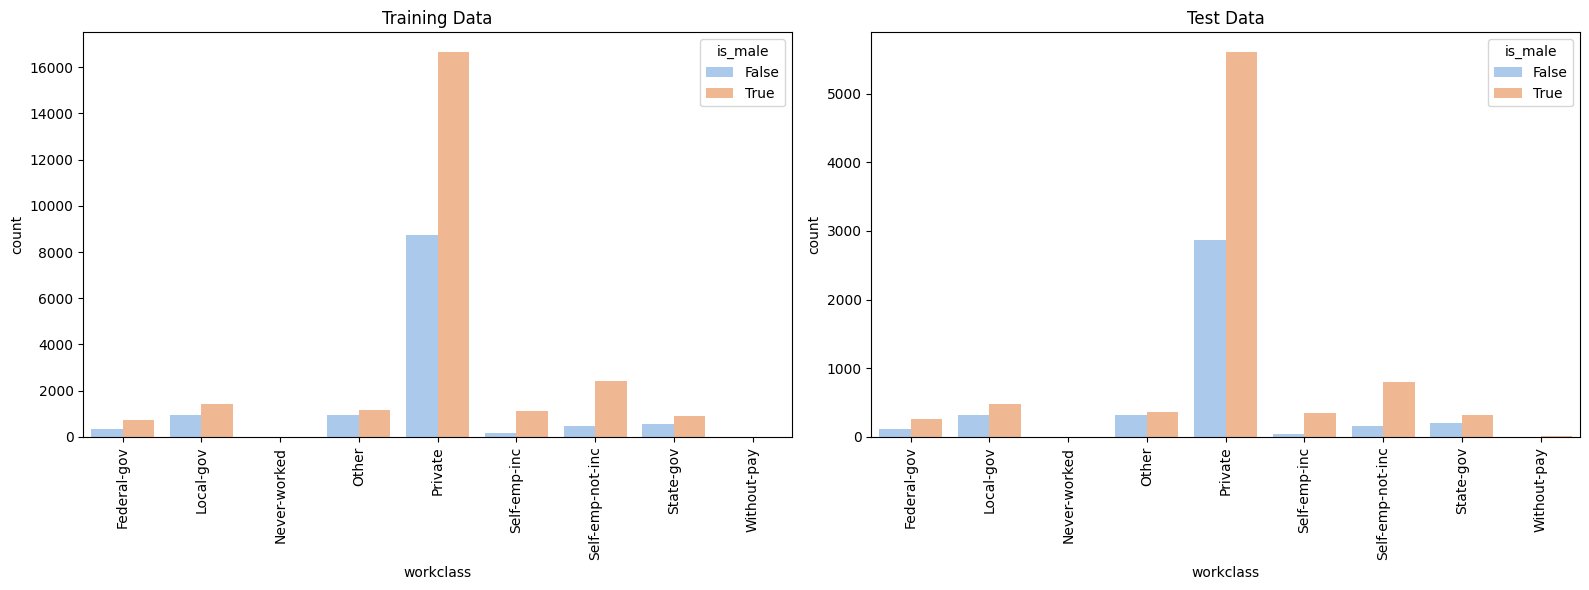

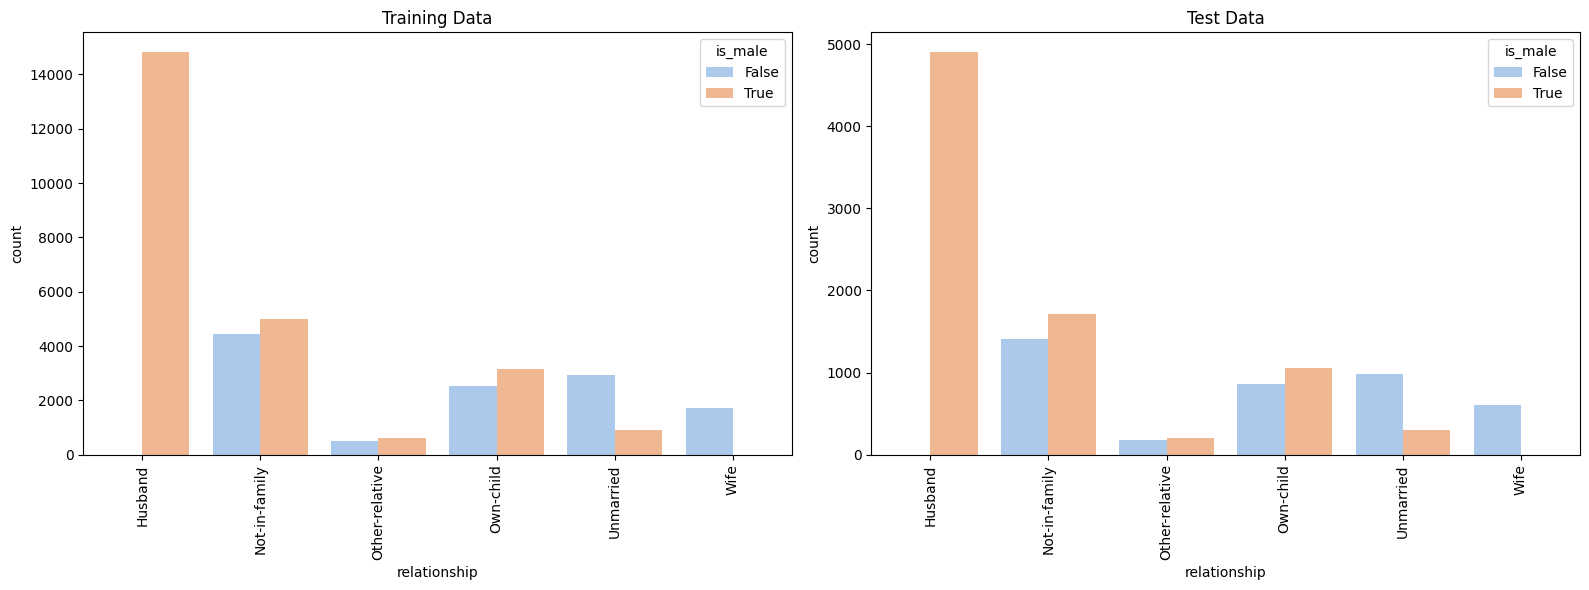

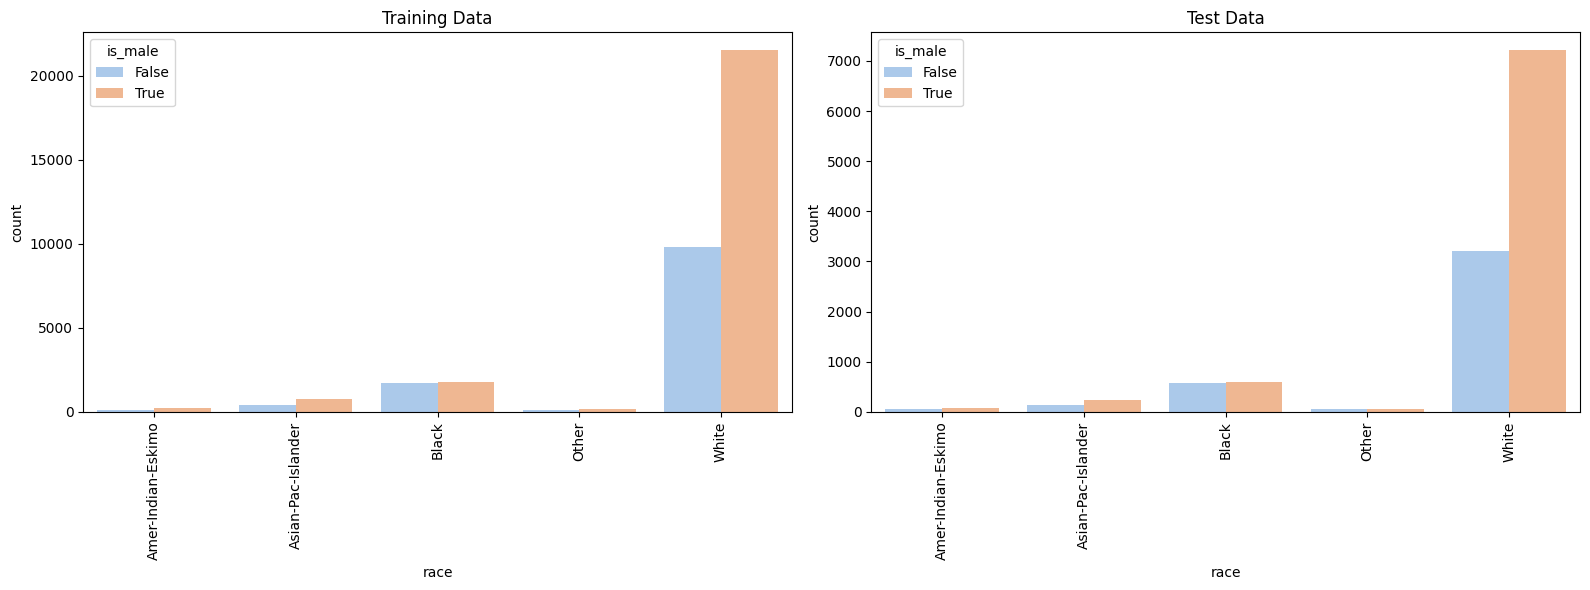

In [128]:
for col in ['occupation', 'workclass', 'relationship', 'race']:
    sns_countplot(df_optimized_train, df_optimized_test, col, hue='is_male', figsize=(16,6))
    plt.show()

**Proportion of High Earners**: A higher proportion of males are high earners compared to females. This basic observation lays the foundation for the pay disparity investigation.

**Age and Working Hours**: Males in the dataset are generally older and work more hours per week than females. Age and experience can often correlate with higher wages, and working longer hours might lead to higher earnings, especially in jobs that pay hourly or have overtime.

**Race and Gender Composition**: There are about twice as many males among Whites as females. Given that White is one of the races with a higher proportion of high earners, this gender disparity in representation could skew overall earnings data.

**Workclass Disparity**: There are significantly fewer women in high-earning workclass types like `federal-gov` and `self-emp-inc`, potentially leading to an underrepresentation of women in higher-earning roles.

**Occupational Segregation**: Women outnumber men in lower-paying roles like `Adm-clerical` & `Other-service`. In contrast, men dominate most other occupations. This points to occupational segregation, where societal norms and stereotypes might pigeonhole genders into certain roles, impacting the gender pay disparity.

### Correlation matrix

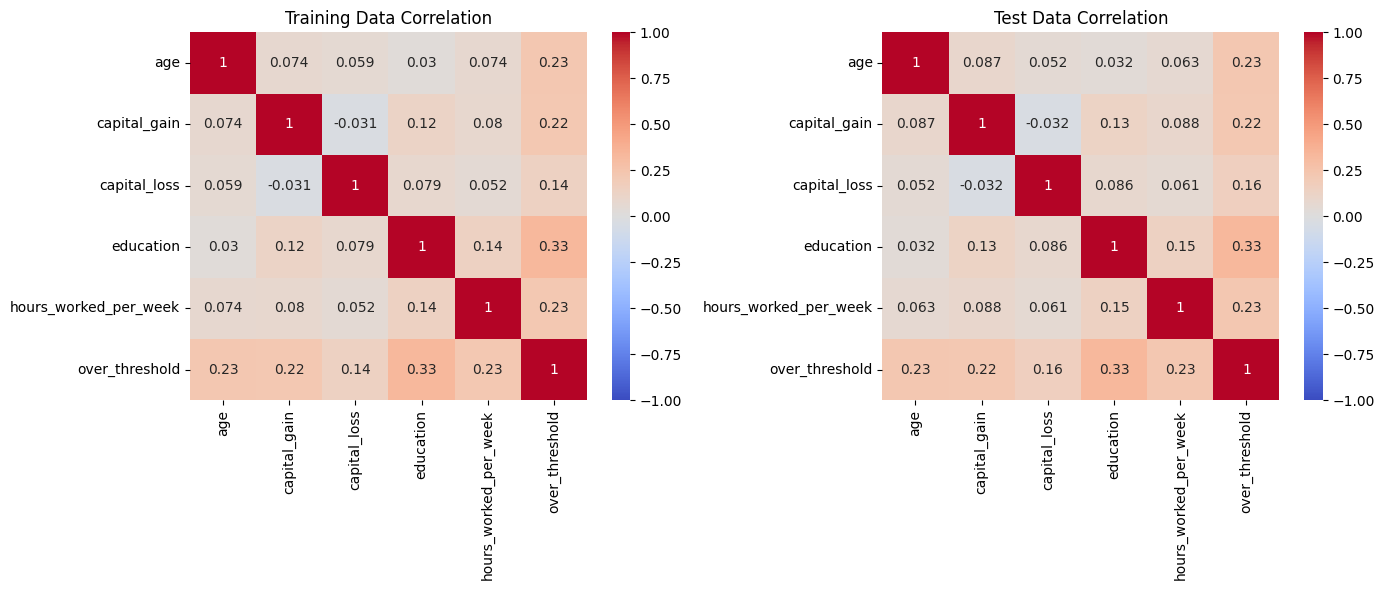

In [129]:
correlation_heatmap(df_optimized_train, df_optimized_test, num_cols, figsize=(14,6))

**EDA Insights:**

1. The distributions in both the training and test sets are roughly comparable.

2. The `Married-civ-spouse` category boasts the highest proportion of high earners.

3. Occupations in `Exec-managerial` and `Prof-specialty` have the highest likelihood of earning more than 50K annually, whereas `Other-service` ranks the lowest.

4. The `Asian-Pac-Islander` and `White` races have the highest proportions of individuals earning above the threshold. Conversely, the `Black` race has the smallest proportion of high earners.

5. The `Husband` and `Wife` categories within relationship types exhibit the greatest proportion of high earners.

6. The proportion of high earners is notably higher among males than females (see my gender pay gap investigation above for more insights).

7. `The Self-emp-inc` and `Federal-gov work` classes have the highest proportions of individuals earning above 50K annually.

8. Individuals who earn more tend to be older, more educated, and typically work longer hours.

9. No signs of multicollinearity were detected among the numerical predictors, as evidenced by the correlation matrix.


### New features ideas

In [130]:
df_test_train = df_optimized_train.copy()
df_test_test = df_optimized_test.copy()

In [131]:
# Marital & Relationship Status
def combined_status(row):
    if row['marital_status'] == 'Married-civ-spouse' and row['relationship'] == 'Husband':
        return 'Married-Husband'
    elif row['marital_status'] == 'Married-civ-spouse' and row['relationship'] == 'Wife':
        return 'Married-Wife'
    elif row['marital_status'] not in ['Married-civ-spouse', 'Married-AF-spouse'] and row['relationship'] == 'Husband':
        return 'Single-Man'
    elif row['marital_status'] not in ['Married-civ-spouse', 'Married-AF-spouse'] and row['relationship'] == 'Wife':
        return 'Single-Woman'
    elif row['marital_status'] in ['Never-married', 'Divorced', 'Separated', 'Widowed']:
        return f"Single-{row['relationship']}"
    elif row['marital_status'] in ['Married-spouse-absent', 'Married-AF-spouse']:
        return f"Married-{row['relationship']}"
    else:
        return 'Other'

In [132]:
df_test_train['combined_status'] = df_optimized_train.apply(combined_status, axis=1)
df_test_test['combined_status'] = df_optimized_test.apply(combined_status, axis=1)

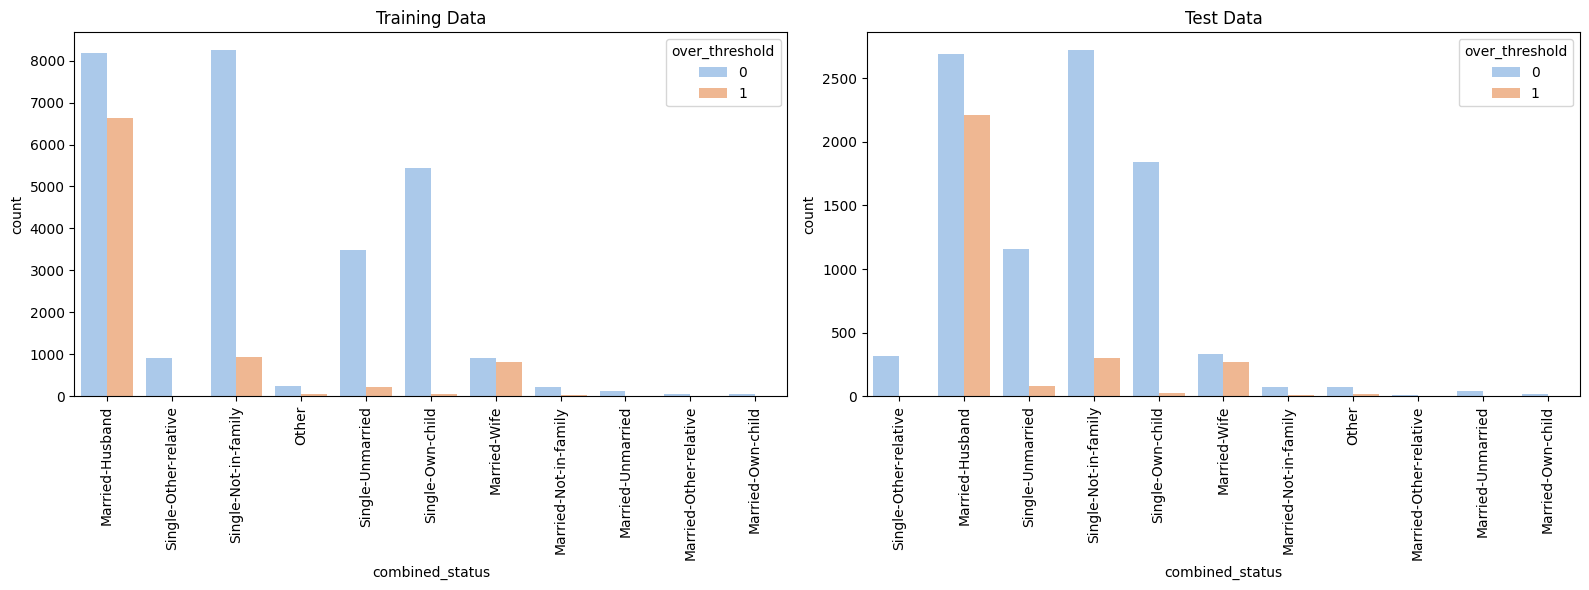

In [133]:
sns_countplot(df_test_train, df_test_test, 'combined_status', hue='over_threshold', figsize=(16,6))

In [134]:
# occupation grouping
def group_occupations(occupation):
    white_collar = ['Exec-managerial', 'Prof-specialty', 'Tech-support', 'Adm-clerical', 'Sales']
    blue_collar = ['Craft-repair', 'Transport-moving', 'Handlers-cleaners', 'Machine-op-inspct', 'Farming-fishing']
    service_jobs = ['Other-service', 'Protective-serv', 'Priv-house-serv']

    if occupation in white_collar:
        return 'White-Collar'
    elif occupation in blue_collar:
        return 'Blue-Collar'
    elif occupation in service_jobs:
        return 'Service'
    else:
        return 'Others/Undefined'

df_optimized_train['occupation_group'] = df_optimized_train['occupation'].apply(group_occupations)

In [135]:
df_test_train['occupation_group'] = df_optimized_train.occupation.apply(group_occupations)
df_test_test['occupation_group'] = df_optimized_test.occupation.apply(group_occupations)

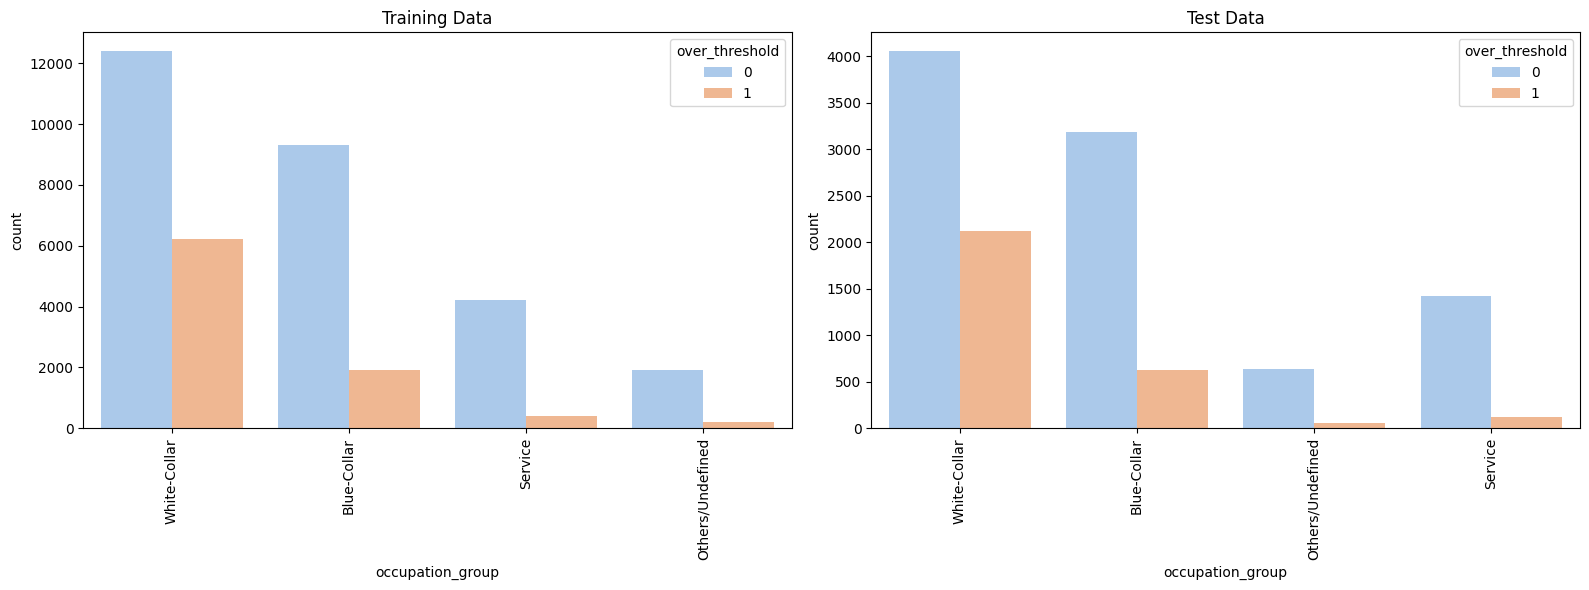

In [136]:
sns_countplot(df_test_train, df_test_test, 'occupation_group', hue='over_threshold', figsize=(16,6))

In [137]:
# privileged
(
    df_optimized
    .query("relationship=='Husband' & race=='White' & (occupation=='Exec-managerial' | occupation=='Prof-specialty')")
).over_threshold.value_counts()

1    3801
0    1628
Name: over_threshold, dtype: int64

## Feature Creation & Transformation

### Define functions

In [138]:
def feature_creation(df_train, df_test):
    """
    Enhances the input DataFrames with new derived features.
    This function adds new categorical and numerical columns to the input DataFrame
    based on certain conditions and transformations:

    1. `age_category`: Categorizes age into five bins: ['Youth', 'Young Adult', 'Middle Aged', 'Senior', 'Elderly'].
    2. `hours_group`: Bins work hours into categories ['Part-time', 'Full-time', 'Overtime', 'Excessive'].
    3. `age_hours_group`: Combines the `age_category` and `hours_group` features into a single categorical variable.
    4. `capital_net`: Represents the net capital, which is the difference between capital gain and capital loss.
    5. `occupation_group`: A higher-level grouping of the original occupation feature.
    6. `combined_status`: Merges the marital_status and relationship features into a single categorical variable.

    Args:
    - df (DataFrame): The input DataFrame to be enhanced.

    Returns:
    - Tuple(DataFrame, DataFrame): The enhanced training and test DataFrames with additional features.
    """

    # Common transformation function
    def create_features(df):
        cols = df.columns.to_list()

        # Define age categories
        labels = ['Youth', 'Young Adult', 'Middle Aged', 'Senior', 'Elderly']
        # Define work hour groups
        bins_hours = [0, 25, 40, 60, 100]
        labels_hours = ['Part-time', 'Full-time', 'Overtime', 'Excessive']
        # Define condition for the new "privileged" feature
        condition = (
            (df['relationship'] == 'Husband') &
            (df['race'] == 'White') &
            ((df['occupation'] == 'Exec-managerial') | (df['occupation'] == 'Prof-specialty'))
        )

        df['age_category'] = pd.cut(df.age, bins=5, labels=labels, right=False, include_lowest=True).astype("category")
        df['hours_group'] = pd.cut(df.hours_worked_per_week, bins=bins_hours, labels=labels_hours, right=False).astype("category")

        # Apply transformations and return dataframe
        return (df
                [cols]
                .assign(
                      	# age_category=pd.cut(df.age, bins=5, labels=labels, right=False, include_lowest=True).astype("category"),
                        # hours_group=pd.cut(df.hours_worked_per_week, bins=bins_hours, labels=labels_hours, right=False).astype("category"),
                        age_hours_group=(df.age_category.astype(str) + ' - ' + df.hours_group.astype(str)).astype("category"),
                        capital_net=df.capital_gain - df.capital_loss,
                        occupation_group=df.occupation.apply(group_occupations).astype("category"),
                        combined_status=df.apply(combined_status, axis=1).astype("category"),
                        # privileged=condition
                        )
                )

    return create_features(df_train), create_features(df_test)

In [139]:
def plot_feature_importance(df_train, target_column):
    """
    Display a bar chart of feature importance using a Decision Tree Classifier.

    This function takes in a dataframe and a target column, encodes categorical features using label encoding,
    fits a Decision Tree Classifier, and then visualizes the feature importances derived from the classifier.

    Args:
    - df (DataFrame): The input data. It can have both categorical and numerical features.
    - target_col (str): The target variable's column name in the dataframe.

    Returns:
    - None. The function displays a bar chart of feature importances.

    Note:
    The function modifies the input dataframe in-place due to label encoding. Consider passing a copy if original
    data preservation is required.
    """

    # Copy the input dataframe to avoid modifying the original
    df_encoded = df_train.copy()

    # Initialize a label encoder
    le = LabelEncoder()

    # Encode each categorical column
    for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
        if col != target_column:  # Exclude target column from encoding
            df_encoded[col] = le.fit_transform(df_encoded[col])

    # Split data into features and target
    X = df_encoded.drop(target_column, axis=1)
    y = df_encoded[target_column]

    # Fit a Decision Tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(X, y)

    # Get feature importances and sort them in descending order
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances
    plt.figure(figsize=(12,6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()

In [140]:
class DataTransformer:
    """
    A class to transform input data for machine learning model preparation.

    This class provides methods to fit transformations based on a provided training dataset
    and to apply these transformations to any dataset. It primarily handles:
    1. Collapsing less frequent native countries into an 'Other' category.
    2. MinMax scaling of selected numerical columns.
    3. One-hot encoding of categorical variables.

    Attributes:
    - top_5_countries (list): A list of top 5 most frequent native countries in the training data.
    - scaler (MinMaxScaler): A MinMaxScaler object to scale numerical columns.
    - scaler_edu (MinMaxScaler): A MinMaxScaler object specifically for the 'education' column.

    Methods:
    - fit(df): Computes necessary parameters (like top 5 countries) and initializes scalers.
    - transform(df): Applies transformations to the input dataframe and returns the transformed dataframe.

    Example:
    >>> transformer = DataTransformer()
    >>> transformer.fit(train_data)
    >>> transformed_data = transformer.transform(test_data)
    """

    def __init__(self):
        self.top_5_countries = None
        self.scaler = None
        self.scaler_edu = None

    def fit(self, df):
        self.top_5_countries = df.native_country.value_counts().head(5).index.tolist()
        self.scaler = MinMaxScaler()
        self.scaler_edu = MinMaxScaler()

        cols_to_scale = ['age', 'capital_gain', 'capital_loss', 'capital_net', 'hours_worked_per_week']
        self.scaler.fit(df[cols_to_scale])
        self.scaler_edu.fit(df[['education']])

    def transform(self, df):
        df = df.copy()
        df['native_country'] = df.native_country.where(df['native_country'].isin(self.top_5_countries), 'Other').astype('category')

        cat_cols = df.select_dtypes('category').columns.to_list()
        df_encoded = pd.get_dummies(df, columns=cat_cols)

        cols_to_scale = ['age', 'capital_gain', 'capital_loss', 'capital_net', 'hours_worked_per_week']
        df_encoded[cols_to_scale] = self.scaler.transform(df_encoded[cols_to_scale])
        df_encoded['education'] = self.scaler_edu.transform(df_encoded[['education']])

        return df_encoded

### Feature creation

In [141]:
df_features_train, df_features_test = feature_creation(df_optimized_train, df_optimized_test)

In [142]:
df_features_train.columns

Index(['age', 'capital_gain', 'capital_loss', 'education',
       'hours_worked_per_week', 'marital_status', 'native_country',
       'occupation', 'race', 'relationship', 'is_male', 'workclass',
       'over_threshold', 'occupation_group', 'age_hours_group', 'capital_net',
       'combined_status'],
      dtype='object')

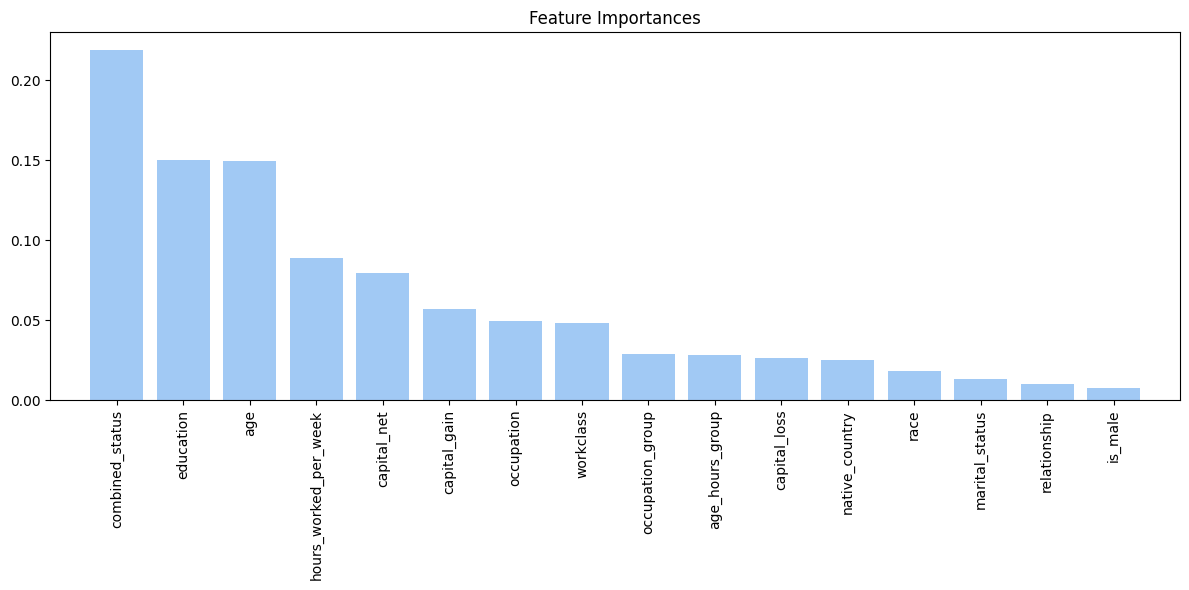

In [143]:
# check feature importance using decision tree classifier
plot_feature_importance(df_features_train, 'over_threshold')

In [144]:
transformer = DataTransformer()

In [145]:
# This code segment involves two primary steps: fitting the data transformer and then transforming datasets.

# 1. Fitting the Data Transformer:
transformer.fit(df_features_train)
# Here, the `fit` method of the `DataTransformer` class is called using the training data `df_features_train`.
# The purpose of this step is for the transformer to learn parameters from the training data which will be used during the transformation phase.
# For instance, in this specific transformer:
# - It identifies the top 5 most frequent native countries.
# - It computes the minimum and maximum values of specific columns, which will be used by the MinMaxScaler for normalization.

# 2. Transforming the Datasets:
df_transformed_train = transformer.transform(df_features_train)
# This line applies the transformations (that the transformer learned in the fit step) to the training data.
# The result is a transformed dataset where, for example, less frequent countries are grouped as 'Other',
# numerical columns are normalized, and categorical columns are one-hot encoded.

df_transformed_test = transformer.transform(df_features_test)
# Similarly, the transformations are also applied to the test data.
# Important note: The test data is transformed using the parameters learned from the training data to ensure consistency and avoid data leakage.
# For example, even if a new country appears in the test data that wasn't in the top 5 of the training data, it will still be grouped as 'Other'.

In [146]:
df_transformed_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36602.0,0.296857,0.188059,0.0,0.150685,0.273973,0.424658,1.0
capital_gain,36602.0,0.010927,0.075274,0.0,0.000000,0.000000,0.000000,1.0
capital_loss,36602.0,0.019737,0.091856,0.0,0.000000,0.000000,0.000000,1.0
education,36602.0,0.605284,0.171004,0.0,0.533333,0.600000,0.733333,1.0
hours_worked_per_week,36602.0,0.402324,0.126482,0.0,0.397959,0.397959,0.448980,1.0
...,...,...,...,...,...,...,...,...
combined_status_Other,36602.0,0.007541,0.086510,0.0,0.000000,0.000000,0.000000,1.0
combined_status_Single-Not-in-family,36602.0,0.251025,0.433609,0.0,0.000000,0.000000,1.000000,1.0
combined_status_Single-Other-relative,36602.0,0.025272,0.156952,0.0,0.000000,0.000000,0.000000,1.0
combined_status_Single-Own-child,36602.0,0.150456,0.357523,0.0,0.000000,0.000000,0.000000,1.0


In [147]:
df_transformed_test.describe().T

,count,mean,std,min,25%,50%,75%,max
age,12206.0,0.295670,0.186978,0.0,0.140411,0.273973,0.424658,1.000000
capital_gain,12206.0,0.010414,0.072323,0.0,0.000000,0.000000,0.000000,1.000000
capital_loss,12206.0,0.021196,0.094587,0.0,0.000000,0.000000,0.000000,0.865473
education,12206.0,0.605025,0.172448,0.0,0.533333,0.600000,0.800000,1.000000
hours_worked_per_week,12206.0,0.402220,0.126361,0.0,0.397959,0.397959,0.448980,1.000000
...,...,...,...,...,...,...,...,...
combined_status_Other,12206.0,0.007455,0.086025,0.0,0.000000,0.000000,0.000000,1.000000
combined_status_Single-Not-in-family,12206.0,0.247911,0.431817,0.0,0.000000,0.000000,0.000000,1.000000
combined_status_Single-Other-relative,12206.0,0.026626,0.160995,0.0,0.000000,0.000000,0.000000,1.000000
combined_status_Single-Own-child,12206.0,0.152466,0.359487,0.0,0.000000,0.000000,0.000000,1.000000


In [148]:
df_transformed_train.shape

(36602, 91)

In summary, with 36,602 instances and 91 features, we're not in an extreme high-dimensionality scenario, but it's always a good idea to be mindful of potential overfitting and computational efficiency. Always validate the performance on a separate set to make sure your model is generalizing well.

## Modeling

We start with some simpler models and proceed to the more complex ones.

As we are dealing with slightly unbalanced classes here, the evaluation **metrics** are:

* **accuracy**: Proportion of all predictions that are correct. It represents how often the model is correct, irrespective of the specific positive or negative class.

* **f1-measure**: Harmonic mean of precision and recall; balances false positives and false negatives; useful for imbalanced datasets.

* **precision**: Proportion of true positive predictions among positive predictions; indicates how often the positive predictions are correct.

* **recall**: Measures the fraction of actual positives correctly identified, highlighting sensitivity to positive instances. It's especially valuable when the cost of false negatives is high or for rare-event detection.

### All features

In [149]:
# Splitting training dataframe into features and target
X_train = df_transformed_train.drop('over_threshold', axis=1)
y_train = df_transformed_train['over_threshold']

# Splitting test dataframe into features and target
X_test = df_transformed_test.drop('over_threshold', axis=1)
y_test = df_transformed_test['over_threshold']

In [150]:
missing_in_test = set(X_train.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X_train.columns)

print("Columns missing in test data:", missing_in_test)
print("Columns missing in training data:", missing_in_train)

Columns missing in test data: set()
Columns missing in training data: set()


In [151]:
# ensure same columns order in bothe sets
X_test = X_test[X_train.columns]

In [152]:
def evaluate_models(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates a set of classifiers on provided training and test data.

    The function trains each classifier using the training data, makes predictions
    on the test data, calculates a set of evaluation metrics, and summarizes the
    results in a dataframe sorted by F1 score in descending order.

    Parameters:
    - X_train (DataFrame or array-like): Features for the training set.
    - y_train (DataFrame or array-like): Target for the training set.
    - X_test (DataFrame or array-like): Features for the test set.
    - y_test (DataFrame or array-like): Target for the test set.

    Returns:
    - DataFrame: A dataframe containing the model name and its corresponding
      evaluation metrics (Accuracy, Precision, Recall, and F1 Score),
      sorted by F1 Score in descending order.

    Models Evaluated:
    - Decision Tree
    - Logistic Regression
    - Naive Bayes
    - Random Forest
    - XGBoost

    Note:
    The Logistic Regression model uses a maximum iteration of 10,000 to ensure convergence,
    and the XGBoost model is set with 'logloss' as its evaluation metric.
    """

    # Define the models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Logistic Regression': LogisticRegression(max_iter=10000),
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(eval_metric='logloss')
    }

    # Lists to store metrics
    model_names = []
    acc_scores = []
    prec_scores = []
    recall_scores = []
    f1_scores = []

    # Loop through models, train, predict, and store metrics
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        model_names.append(name)
        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    # Create a dataframe to hold results
    results_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': acc_scores,
        'Precision': prec_scores,
        'Recall': recall_scores,
        'F1 Score': f1_scores
    }).sort_values(by='F1 Score', ascending=False)

    return results_df

In [153]:
results = evaluate_models(X_train, y_train, X_test, y_test)
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
4              XGBoost  0.873587   0.779037  0.658795  0.713888
1  Logistic Regression  0.857119   0.746032  0.611225  0.671934
3        Random Forest  0.847534   0.707632  0.618754  0.660215
0        Decision Tree  0.818942   0.625352  0.607803  0.616453
2          Naive Bayes  0.651893   0.400301  0.911704  0.556333


### Feature selection

With fewer features, there's a reduced risk of overfitting, especially for models like the Decision Tree. Also, simpler models with fewer features can be more interpretable, which can be an advantage in certain applications.

In [154]:
def feature_selection(X_train, X_test, n_features=20):
    """
    Performs feature selection based on the importances derived from a Decision Tree Classifier.

    The function trains a Decision Tree Classifier on the given training set to determine
    feature importances. It then ranks these features based on their importances and
    returns transformed versions of the provided training and test datasets that retain
    only the top n features. A bar chart visualizing the importance scores of the
    top n features is also displayed.

    Parameters:
    - X_train (DataFrame or array-like): Features for the training set.
    - X_test (DataFrame or array-like): Features for the test set.
    - n_features (int, optional): Number of top features to select. Default is 20.

    Returns:
    - X_train_reduced (DataFrame or array-like): Training data with only the top n features.
    - X_test_reduced (DataFrame or array-like): Test data with only the top n features.

    Note:
    The function assumes that y_train (target for training data) is available in the environment.
    It's advisable to ensure that y_train is appropriately defined before calling this function.

    Example Usage:
    If you want to select the top 10 features based on importance:
    X_train_10, X_test_10 = feature_selection(X_train, X_test, n_features=10)
    """

    # 1. Train a Decision Tree Classifier to get feature importances
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)  # Assuming y_train is available in the environment

    # 2. Extract feature importances and feature names, and put them into a DataFrame
    feature_importances = dt.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    }).sort_values(by="Importance", ascending=False)

    # 3. Select top n features
    top_features = features_df.head(n_features)["Feature"].tolist()

    # 4. Transform X_train and X_test to retain only the top features
    X_train_reduced = X_train[top_features]
    X_test_reduced = X_test[top_features]

    # Bonus: Display a column chart with ordered feature importance scores
    plt.figure(figsize=(12, 8))
    plt.barh(top_features, features_df.head(n_features)["Importance"], align='center')
    plt.gca().invert_yaxis()  # Display the most important feature at the top
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {n_features} Feature Importances")
    plt.show()

    return X_train_reduced, X_test_reduced

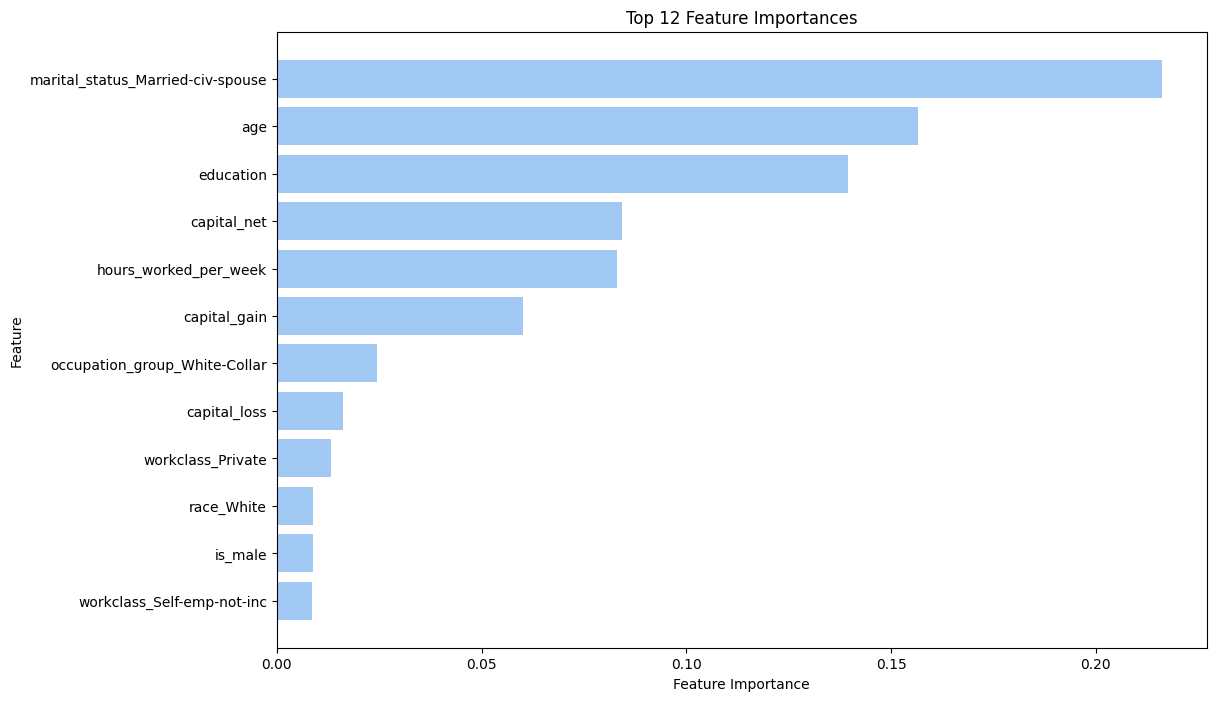

In [155]:
X_train_reduced, X_test_reduced = feature_selection(X_train, X_test, n_features=12)

In [156]:
results = evaluate_models(X_train_reduced, y_train, X_test_reduced, y_test)
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
4              XGBoost  0.870064   0.768921  0.653662  0.706622
3        Random Forest  0.848107   0.705701  0.626968  0.664009
1  Logistic Regression  0.852040   0.742188  0.585216  0.654420
0        Decision Tree  0.828281   0.654220  0.599589  0.625714
2          Naive Bayes  0.801327   0.683938  0.316222  0.432483


### Final model selection and fine-tuning

Although XGBoost exhibits the pest performance among all testet models, I am willing to select Logistic Regression for its better interpretability.

In [157]:
def tune_logistic_regression(X_train, y_train, X_test, y_test):
    """
    Performs hyperparameter tuning for a Logistic Regression model using Grid Search.

    The function uses GridSearchCV to find the best hyperparameters from a specified
    grid for a Logistic Regression model. The tuning process aims to maximize accuracy,
    but also considers other metrics such as precision, recall, and F1 score.
    After the optimal parameters are found, the function evaluates the best model on
    the test set, returning the performance metrics and best hyperparameters.

    Parameters:
    - X_train (DataFrame or array-like): Training data features.
    - y_train (DataFrame or array-like): Training data target.
    - X_test (DataFrame or array-like): Test data features.
    - y_test (DataFrame or array-like): Test data target.

    Returns:
    - A tuple containing:
      1. A string with the best hyperparameters found.
      2. A DataFrame with evaluation metrics (Accuracy, Precision, Recall, and F1 Score)
         for the best model on the test data.

    Example Usage:
    best_params, performance_df = tune_logistic_regression(X_train, y_train, X_test, y_test)
    """

    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }

    grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=5000),
                               param_grid=param_grid,
                               scoring=['accuracy', 'precision', 'recall', 'f1'],
                               refit='accuracy',
                               cv=5,
                               verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)

    # Collect metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    result = {
        'Model': 'Logistic Regression',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Convert result to a DataFrame
    df_result = pd.DataFrame([result])

    return f"Best parameters: {grid_search.best_params_}\n", df_result

In [158]:
best_params, results_df = tune_logistic_regression(X_train_reduced, y_train, X_test_reduced, y_test)
print(best_params)
print(results_df)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.853679   0.743777  0.593087  0.659939


A few points on the results:

The **Accuracy** indicates that the model classifies about 85.38% of the samples correctly.

**Precision** tells us that of the instances the model predicted as positive, 74.38% were actually positive.

**Recall** (or Sensitivity) indicates that the model correctly identified 59.31% of all actual positive instances.

The **F1 Score** is a harmonic mean of precision and recall, which helps to account for the trade-off between the two. An F1 Score of 66% is decent, especially given that logistic regression is a simple, linear model.

Given this, the Logistic Regression model seems to be working reasonably well. The hyperparameters selected **('C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear')** suggest a relatively strong regularization (via the l1 penalty and C=10). The solver **'liblinear'** is often a good choice for small to medium datasets.

Remember, while these metrics provide an indication of performance, the final choice of whether the model is 'good enough' depends on our specific application and requirements. If the **recall**, for instance, is of paramount importance, then we might want to explore further strategies to improve it.

### Results interpretation

In [159]:
feature_names = X_train_reduced.columns.to_list()
best_params = {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

In [179]:
def logistic_coefficients(X_train, y_train, feature_names, best_params, visualize=True):
    """
    Instantiates, fits a logistic regression model using the best parameters,
    and then either plots the coefficients or returns them as a table.

    Parameters:
    - X_train: Training data.
    - y_train: Labels for training data.
    - feature_names: A list of feature names.
    - best_params: Dictionary of best hyperparameters for the model.
    - visualize: A flag to decide if the coefficients should be visualized or returned as a table.

    Returns:
    - If visualize=True, a plot is shown and nothing is returned.
    - If visualize=False, a DataFrame containing the coefficients is returned.
    """

    # Instantiate and fit the logistic regression model with best parameters
    model = LogisticRegression(**best_params)
    model.fit(X_train, y_train)

    # Extract coefficients
    coefficients = model.coef_[0]

    # Get min and max values for the features in the original data
    pattern = r"_([A-Z])"  # Matches an underscore followed by a capital letter for one-hot encoded features
    relevant_original_features = [feature for feature in feature_names if not re.search(pattern, feature) and not 'is_male']
    min_values = df_features_train[relevant_original_features].min()
    max_values = df_features_train[relevant_original_features].max()

    # Create a mapping of feature to its scale range
    feature_ranges = {}
    for feature in feature_names:
        if feature in relevant_original_features:
            feature_ranges[feature] = max_values[feature] - min_values[feature]
        else:
            # For one-hot encoded binary features, the range is 1 (from 0 to 1)
            feature_ranges[feature] = 1

    # Calculate original coefficients from scaled coefficients
    original_coefficients = [coeff / feature_ranges[feature] for coeff, feature in zip(coefficients, feature_names)]

    # Replace the scaled coefficients with the adjusted coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': original_coefficients
    })
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

    # Decide whether to visualize or return the coefficients
    if visualize:
        plt.figure(figsize=(8, 6))
        plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature Name')
        plt.title('Logistic Regression Coefficients')
        plt.gca().invert_yaxis()  # Show the largest coefficients at the top
        plt.show()
    else:
        return coef_df

In [180]:
# show coef values
logistic_coefficients(X_train_reduced,
                      y_train,
                      feature_names,
                      best_params,
                      visualize=False)

,Feature,Coefficient
5,capital_gain,31.880202
2,education,4.486986
4,hours_worked_per_week,2.997692
7,capital_loss,2.742346
0,marital_status_Married-civ-spouse,2.482366
1,age,1.985912
6,occupation_group_White-Collar,0.726222
9,race_White,0.270361
10,is_male,0.195679
8,workclass_Private,0.001871


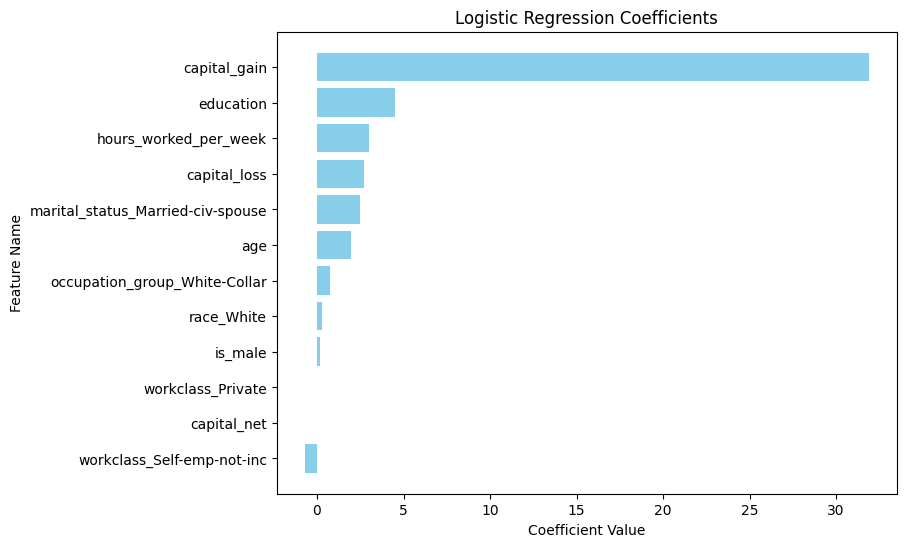

In [181]:
# visualize coefficients
logistic_coefficients(X_train_reduced,
                      y_train,
                      feature_names,
                      best_params,
                      visualize=True)

**Interpretation of Coefficients**:

**capital_gain**: With the highest coefficient value of approximately 31.88, it indicates that as capital gain increases, the log-odds of a person earning above 50K annually increases most substantially. Essentially, higher capital gains are strongly associated with higher incomes.

**education**: A coefficient of approximately 4.49 suggests that with each unit increase in the education level (assuming it's numerically encoded), the log-odds of earning above 50K annually also increase. Higher education levels generally correspond to higher incomes.

**hours_worked_per_week**: This positive coefficient (around 3.00) indicates that working more hours per week is associated with higher chances of earning above 50K annually.

**capital_loss**: With a coefficient of about 2.74, as capital loss increases, the probability of earning more than 50K annually increases. This might seem counterintuitive at first, but people with higher incomes may have more investments, and hence, might have more avenues where they can incur capital losses.

**marital_status_Married-civ-spouse**: A person with the marital status of "Married-civ-spouse" has approximately 2.56 times higher log-odds of earning above 50K compared to those who aren't. It's possible that combined household incomes or stability associated with marriage plays a role in this.

**age**: As age increases by one unit, the log-odds of earning above 50K annually increases by around 1.97. This suggests that older individuals, possibly due to more experience or seniority, tend to earn higher incomes.

**occupation_Exec-managerial** and **occupation_Prof-specialty**: These occupations, with coefficients of approximately 0.59 and 0.33 respectively, have higher log-odds of earning above 50K. Executives, managers, and professionals usually have higher salaries compared to other job roles.

**occupation_group_White-Collar**: Individuals in white-collar jobs have around 0.47 times higher log-odds of earning more than 50K annually compared to others.

**workclass_Private**: Being in the private work class provides a slight increase in the log-odds (about 0.04) of earning above 50K compared to other work classes.

**capital_net**: This coefficient is zero, indicating it doesn't influence the prediction much. This might be because it's derived from capital_gain and capital_loss, which are already accounted for.

**workclass_Self-emp-not-inc**: Being self-employed but not incorporated is associated with a decrease in the log-odds (around -0.66) of earning more than 50K annually. This might indicate that such individuals, while self-employed, don't necessarily have the stability or revenue of incorporated businesses.

**Conclusion:**

Factors like capital gain, education level, hours worked per week, and age play significant roles in determining whether an individual earns above 50K annually. Marital status and occupation also have notable influences. However, it's crucial to remember that correlation does not imply causation, and these findings are based on the model's understanding of the data it was trained on.